# SuperTuxKart Telemetry Analysis: Game Frustration Level

This notebook analyzes gameplay sessions from SuperTuxKart telemetry data to compute frustration scores for each session.

## Frustration Score Formula

$$FrustrationScore = w_1 \cdot OffGroundRatio + w_2 \cdot AvgOffGroundDuration + w_3 \cdot OffGroundEventFrequency$$

Where:
- **OffGroundRatio**: Proportion of time spent off-ground (0-1)
- **AvgOffGroundDuration**: Average duration of off-ground events (seconds)
- **OffGroundEventFrequency**: Number of off-ground events per minute
- **Weights**: $w_1 = 0.4$, $w_2 = 0.4$, $w_3 = 0.2$

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import os
from datetime import datetime

# Set style for better visualizations
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load All Telemetry Sessions

In [2]:
def load_telemetry_data(file_path):
    """Load telemetry data from a CSV file and extract metadata."""
    # Read metadata from comments
    metadata = {}
    with open(file_path, 'r') as f:
        for line in f:
            if line.startswith('#') and ':' in line:
                key, value = line[1:].strip().split(':', 1)
                metadata[key.strip()] = value.strip()
            elif not line.startswith('#'):
                break
    
    # Read the actual data
    df = pd.read_csv(file_path, comment='#')
    
    # Add session identifier
    session_name = os.path.basename(file_path).replace('.csv', '')
    df['session'] = session_name
    
    # Add metadata
    for key, value in metadata.items():
        df[key] = value
    
    return df, metadata

# Load all CSV files
csv_files = sorted(glob('telemetry_*.csv'))
print(f"Found {len(csv_files)} telemetry sessions")

# Load all sessions
all_sessions = []
session_metadata = {}

for file in csv_files:
    df, meta = load_telemetry_data(file)
    all_sessions.append(df)
    session_metadata[os.path.basename(file).replace('.csv', '')] = meta
    print(f"✓ Loaded {file}: {len(df)} records")

# Combine all sessions
combined_df = pd.concat(all_sessions, ignore_index=True)
print(f"\nTotal records across all sessions: {len(combined_df)}")
print(f"Columns: {list(combined_df.columns)}")

Found 34 telemetry sessions
✓ Loaded telemetry_20251111_124504.csv: 23109 records
✓ Loaded telemetry_20251111_221300.csv: 3866 records
✓ Loaded telemetry_20251113_210838.csv: 23418 records
✓ Loaded telemetry_20251113_211211.csv: 18325 records
✓ Loaded telemetry_20251113_211506.csv: 25823 records
✓ Loaded telemetry_20251113_211900.csv: 26120 records
✓ Loaded telemetry_20251113_212259.csv: 21172 records
✓ Loaded telemetry_20251113_212618.csv: 22221 records
✓ Loaded telemetry_20251113_212942.csv: 22063 records
✓ Loaded telemetry_20251113_213310.csv: 26168 records
✓ Loaded telemetry_20251113_213720.csv: 25105 records
✓ Loaded telemetry_20251115_192307.csv: 17720 records
✓ Loaded telemetry_20251115_222117.csv: 22147 records
✓ Loaded telemetry_20251115_222444.csv: 21262 records
✓ Loaded telemetry_20251115_222800.csv: 18858 records
✓ Loaded telemetry_20251115_223103.csv: 18964 records
✓ Loaded telemetry_20251115_223414.csv: 18321 records
✓ Loaded telemetry_20251115_233947.csv: 19773 records
✓

## 3. Calculate Frustration Metrics

We'll compute three key metrics for each session:
1. **Off-Ground Ratio**: % of time spent airborne/off-track
2. **Average Off-Ground Duration**: Mean duration of off-ground events
3. **Off-Ground Event Frequency**: Events per minute of gameplay

In [3]:
def calculate_frustration_metrics(session_df):
    """Calculate frustration metrics for a single session."""
    
    # Basic stats
    total_time = session_df['time'].max() - session_df['time'].min()
    total_records = len(session_df)
    
    # Off-ground ratio
    off_ground_records = (session_df['on_ground'] == 0).sum()
    off_ground_ratio = off_ground_records / total_records if total_records > 0 else 0
    
    # Detect off-ground events (transitions from on_ground=1 to on_ground=0)
    session_df = session_df.sort_values('time').reset_index(drop=True)
    session_df['ground_change'] = session_df['on_ground'].diff()
    
    # Start of off-ground event: ground_change == -1
    # End of off-ground event: ground_change == 1
    off_ground_starts = session_df[session_df['ground_change'] == -1].index
    off_ground_ends = session_df[session_df['ground_change'] == 1].index
    
    # Calculate durations of off-ground events
    off_ground_durations = []
    
    for start_idx in off_ground_starts:
        # Find the next end after this start
        next_ends = off_ground_ends[off_ground_ends > start_idx]
        if len(next_ends) > 0:
            end_idx = next_ends[0]
            duration = session_df.loc[end_idx, 'time'] - session_df.loc[start_idx, 'time']
            off_ground_durations.append(duration)
    
    # Handle case where session ends while off-ground
    if len(off_ground_starts) > 0 and (len(off_ground_ends) == 0 or off_ground_starts[-1] > off_ground_ends[-1]):
        last_start = off_ground_starts[-1]
        duration = session_df['time'].max() - session_df.loc[last_start, 'time']
        off_ground_durations.append(duration)
    
    # Calculate metrics
    num_off_ground_events = len(off_ground_durations)
    avg_off_ground_duration = np.mean(off_ground_durations) if off_ground_durations else 0
    
    # Events per minute
    total_minutes = total_time / 60 if total_time > 0 else 1
    event_frequency = num_off_ground_events / total_minutes
    
    return {
        'off_ground_ratio': off_ground_ratio,
        'avg_off_ground_duration': avg_off_ground_duration,
        'event_frequency': event_frequency,
        'num_events': num_off_ground_events,
        'total_time': total_time,
        'total_records': total_records
    }

# Calculate metrics for each session
frustration_data = []

for session_name in combined_df['session'].unique():
    session_df = combined_df[combined_df['session'] == session_name].copy()
    metrics = calculate_frustration_metrics(session_df)
    
    # Add session info
    metrics['session'] = session_name
    metrics['track'] = session_df['Track'].iloc[0] if 'Track' in session_df.columns else 'Unknown'
    metrics['difficulty'] = session_df['Difficulty'].iloc[0] if 'Difficulty' in session_df.columns else 'Unknown'
    
    frustration_data.append(metrics)

frustration_df = pd.DataFrame(frustration_data)
print("Frustration metrics calculated for all sessions:")
print(frustration_df.head())

Frustration metrics calculated for all sessions:
   off_ground_ratio  avg_off_ground_duration  event_frequency  num_events  \
0          0.035960                 1.731275         1.246321           4   
1          0.056130                 1.808300         1.862874           1   
2          0.015373                 1.500000         0.614938           2   
3          0.019973                 0.508350         2.357564           6   
4          0.041823                 0.818191         3.067153          11   

   total_time  total_records                    session                track  \
0    192.5667          23109  telemetry_20251111_124504   cornfield_crossing   
1     32.2083           3866  telemetry_20251111_221300   cornfield_crossing   
2    195.1417          23418  telemetry_20251113_210838             scotland   
3    152.7000          18325  telemetry_20251113_211211          snowtuxpeak   
4    215.1833          25823  telemetry_20251113_211506  ravenbridge_mansion   

  diffi

## 3.5 Calculate Velocity-Based Frustration Metrics

Rapid changes in velocity indicate collisions, sudden stops, or loss of control - all frustrating events.

In [4]:
def calculate_velocity_metrics(session_df):
    """Calculate velocity-based frustration metrics for a single session."""
    
    # Sort by time
    session_df = session_df.sort_values('time').reset_index(drop=True)
    
    # Calculate velocity change (acceleration/deceleration)
    session_df['velocity_change'] = session_df['speed'].diff().abs()
    
    # Define "rapid" velocity change threshold (e.g., speed change > 5 units per timestep)
    # Adjust this threshold based on your game's speed scale
    rapid_change_threshold = 5.0
    
    # Identify rapid velocity changes
    session_df['rapid_velocity_change'] = session_df['velocity_change'] > rapid_change_threshold
    
    # Calculate metrics
    total_records = len(session_df)
    rapid_change_count = session_df['rapid_velocity_change'].sum()
    rapid_change_ratio = rapid_change_count / total_records if total_records > 0 else 0
    
    # Average magnitude of rapid changes
    rapid_changes = session_df[session_df['rapid_velocity_change']]['velocity_change']
    avg_rapid_change_magnitude = rapid_changes.mean() if len(rapid_changes) > 0 else 0
    
    # Frequency of rapid changes (per minute)
    total_time = session_df['time'].max() - session_df['time'].min()
    total_minutes = total_time / 60 if total_time > 0 else 1
    rapid_change_frequency = rapid_change_count / total_minutes
    
    # Calculate standard deviation of speed (measure of stability)
    speed_std = session_df['speed'].std()
    
    return {
        'rapid_change_ratio': rapid_change_ratio,
        'avg_rapid_change_magnitude': avg_rapid_change_magnitude,
        'rapid_change_frequency': rapid_change_frequency,
        'rapid_change_count': rapid_change_count,
        'speed_std': speed_std
    }

# Calculate velocity metrics for each session
velocity_data = []

for session_name in combined_df['session'].unique():
    session_df = combined_df[combined_df['session'] == session_name].copy()
    velocity_metrics = calculate_velocity_metrics(session_df)
    velocity_metrics['session'] = session_name
    velocity_data.append(velocity_metrics)

velocity_df = pd.DataFrame(velocity_data)

# Merge with existing frustration data
frustration_df = frustration_df.merge(velocity_df, on='session', how='left')

print("Velocity-based metrics calculated and merged:")
print(frustration_df[['session', 'rapid_change_ratio', 'avg_rapid_change_magnitude', 
                      'rapid_change_frequency', 'speed_std']].head(10))

Velocity-based metrics calculated and merged:
                     session  rapid_change_ratio  avg_rapid_change_magnitude  \
0  telemetry_20251111_124504            0.000130                   12.953500   
1  telemetry_20251111_221300            0.000259                   10.703400   
2  telemetry_20251113_210838            0.000171                   16.385050   
3  telemetry_20251113_211211            0.000164                   18.778800   
4  telemetry_20251113_211506            0.000310                   10.488575   
5  telemetry_20251113_211900            0.000077                   12.670250   
6  telemetry_20251113_212259            0.000142                   16.976567   
7  telemetry_20251113_212618            0.000090                   16.819200   
8  telemetry_20251113_212942            0.000091                   16.261100   
9  telemetry_20251113_213310            0.000076                   15.139650   

   rapid_change_frequency  speed_std  
0                0.934741   4.3640

## 4. Compute Three Frustration Scores

We'll calculate three versions:
1. **Ground-Based Score**: Using off-ground metrics only (original)
2. **Velocity-Based Score**: Using rapid velocity change metrics only (new)
3. **Combined Score**: Using both ground and velocity metrics (comprehensive)

In [5]:
# ============================================================================
# 1. GROUND-BASED FRUSTRATION SCORE (Original)
# ============================================================================
w1_ground = 0.4  # Off-ground ratio weight
w2_ground = 0.4  # Average off-ground duration weight
w3_ground = 0.2  # Event frequency weight

# Normalize ground-based metrics to 0-1 scale
frustration_df['norm_off_ground_ratio'] = frustration_df['off_ground_ratio']
frustration_df['norm_avg_duration'] = (frustration_df['avg_off_ground_duration'] - 
                                        frustration_df['avg_off_ground_duration'].min()) / \
                                       (frustration_df['avg_off_ground_duration'].max() - 
                                        frustration_df['avg_off_ground_duration'].min() + 1e-10)
frustration_df['norm_event_frequency'] = (frustration_df['event_frequency'] - 
                                          frustration_df['event_frequency'].min()) / \
                                         (frustration_df['event_frequency'].max() - 
                                          frustration_df['event_frequency'].min() + 1e-10)

# Calculate ground-based frustration score
frustration_df['ground_frustration_score'] = (w1_ground * frustration_df['norm_off_ground_ratio'] + 
                                               w2_ground * frustration_df['norm_avg_duration'] + 
                                               w3_ground * frustration_df['norm_event_frequency'])
frustration_df['ground_frustration_100'] = frustration_df['ground_frustration_score'] * 100

# ============================================================================
# 2. VELOCITY-BASED FRUSTRATION SCORE (New)
# ============================================================================
v1 = 0.4  # Rapid change ratio weight
v2 = 0.3  # Average rapid change magnitude weight
v3 = 0.3  # Rapid change frequency weight

# Normalize velocity-based metrics to 0-1 scale
frustration_df['norm_rapid_change_ratio'] = frustration_df['rapid_change_ratio']
frustration_df['norm_rapid_change_magnitude'] = (frustration_df['avg_rapid_change_magnitude'] - 
                                                  frustration_df['avg_rapid_change_magnitude'].min()) / \
                                                 (frustration_df['avg_rapid_change_magnitude'].max() - 
                                                  frustration_df['avg_rapid_change_magnitude'].min() + 1e-10)
frustration_df['norm_rapid_change_frequency'] = (frustration_df['rapid_change_frequency'] - 
                                                  frustration_df['rapid_change_frequency'].min()) / \
                                                 (frustration_df['rapid_change_frequency'].max() - 
                                                  frustration_df['rapid_change_frequency'].min() + 1e-10)

# Calculate velocity-based frustration score
frustration_df['velocity_frustration_score'] = (v1 * frustration_df['norm_rapid_change_ratio'] + 
                                                 v2 * frustration_df['norm_rapid_change_magnitude'] + 
                                                 v3 * frustration_df['norm_rapid_change_frequency'])
frustration_df['velocity_frustration_100'] = frustration_df['velocity_frustration_score'] * 100

# ============================================================================
# 3. COMBINED FRUSTRATION SCORE (Comprehensive)
# ============================================================================
# Weights for combining ground and velocity scores
ground_weight = 0.5
velocity_weight = 0.5

# Calculate combined frustration score
frustration_df['combined_frustration_score'] = (ground_weight * frustration_df['ground_frustration_score'] + 
                                                 velocity_weight * frustration_df['velocity_frustration_score'])
frustration_df['combined_frustration_100'] = frustration_df['combined_frustration_score'] * 100

# Sort by combined frustration score
frustration_df = frustration_df.sort_values('combined_frustration_100', ascending=False).reset_index(drop=True)

# Display results for all three scores
print("=" * 120)
print("FRUSTRATION SCORE COMPARISON (Sorted by Combined Score)")
print("=" * 120)
print(frustration_df[['session', 'ground_frustration_100', 'velocity_frustration_100', 
                      'combined_frustration_100', 'track']].to_string(index=False))
print("=" * 120)

print("\n" + "=" * 120)
print("DETAILED METRICS")
print("=" * 120)
print(frustration_df[['session', 'off_ground_ratio', 'rapid_change_ratio', 
                      'avg_off_ground_duration', 'avg_rapid_change_magnitude']].head(10).to_string(index=False))
print("=" * 120)

FRUSTRATION SCORE COMPARISON (Sorted by Combined Score)
                  session  ground_frustration_100  velocity_frustration_100  combined_frustration_100               track
telemetry_20251116_094605               18.395077                 56.646883                 37.520980               abyss
telemetry_20251115_223414               33.566081                 26.245558                 29.905820           sandtrack
telemetry_20251115_233947               33.536105                 25.684823                 29.610464            scotland
telemetry_20251115_235951               35.592672                 21.610600                 28.601636            hacienda
telemetry_20251116_095843               22.140957                 34.924408                 28.532682 ravenbridge_mansion
telemetry_20251116_001621               34.240234                 22.549619                 28.394927               abyss
telemetry_20251115_234421               37.245686                 19.422954               

### 4.1 Comparison of All Three Frustration Scores

/var/folders/_f/2sn94tkj58z3_mbw0nny1wsh0000gn/T/ipykernel_42696/1059720965.py:62: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax4.boxplot(box_data, labels=['Ground-Based', 'Velocity-Based', 'Combined'],


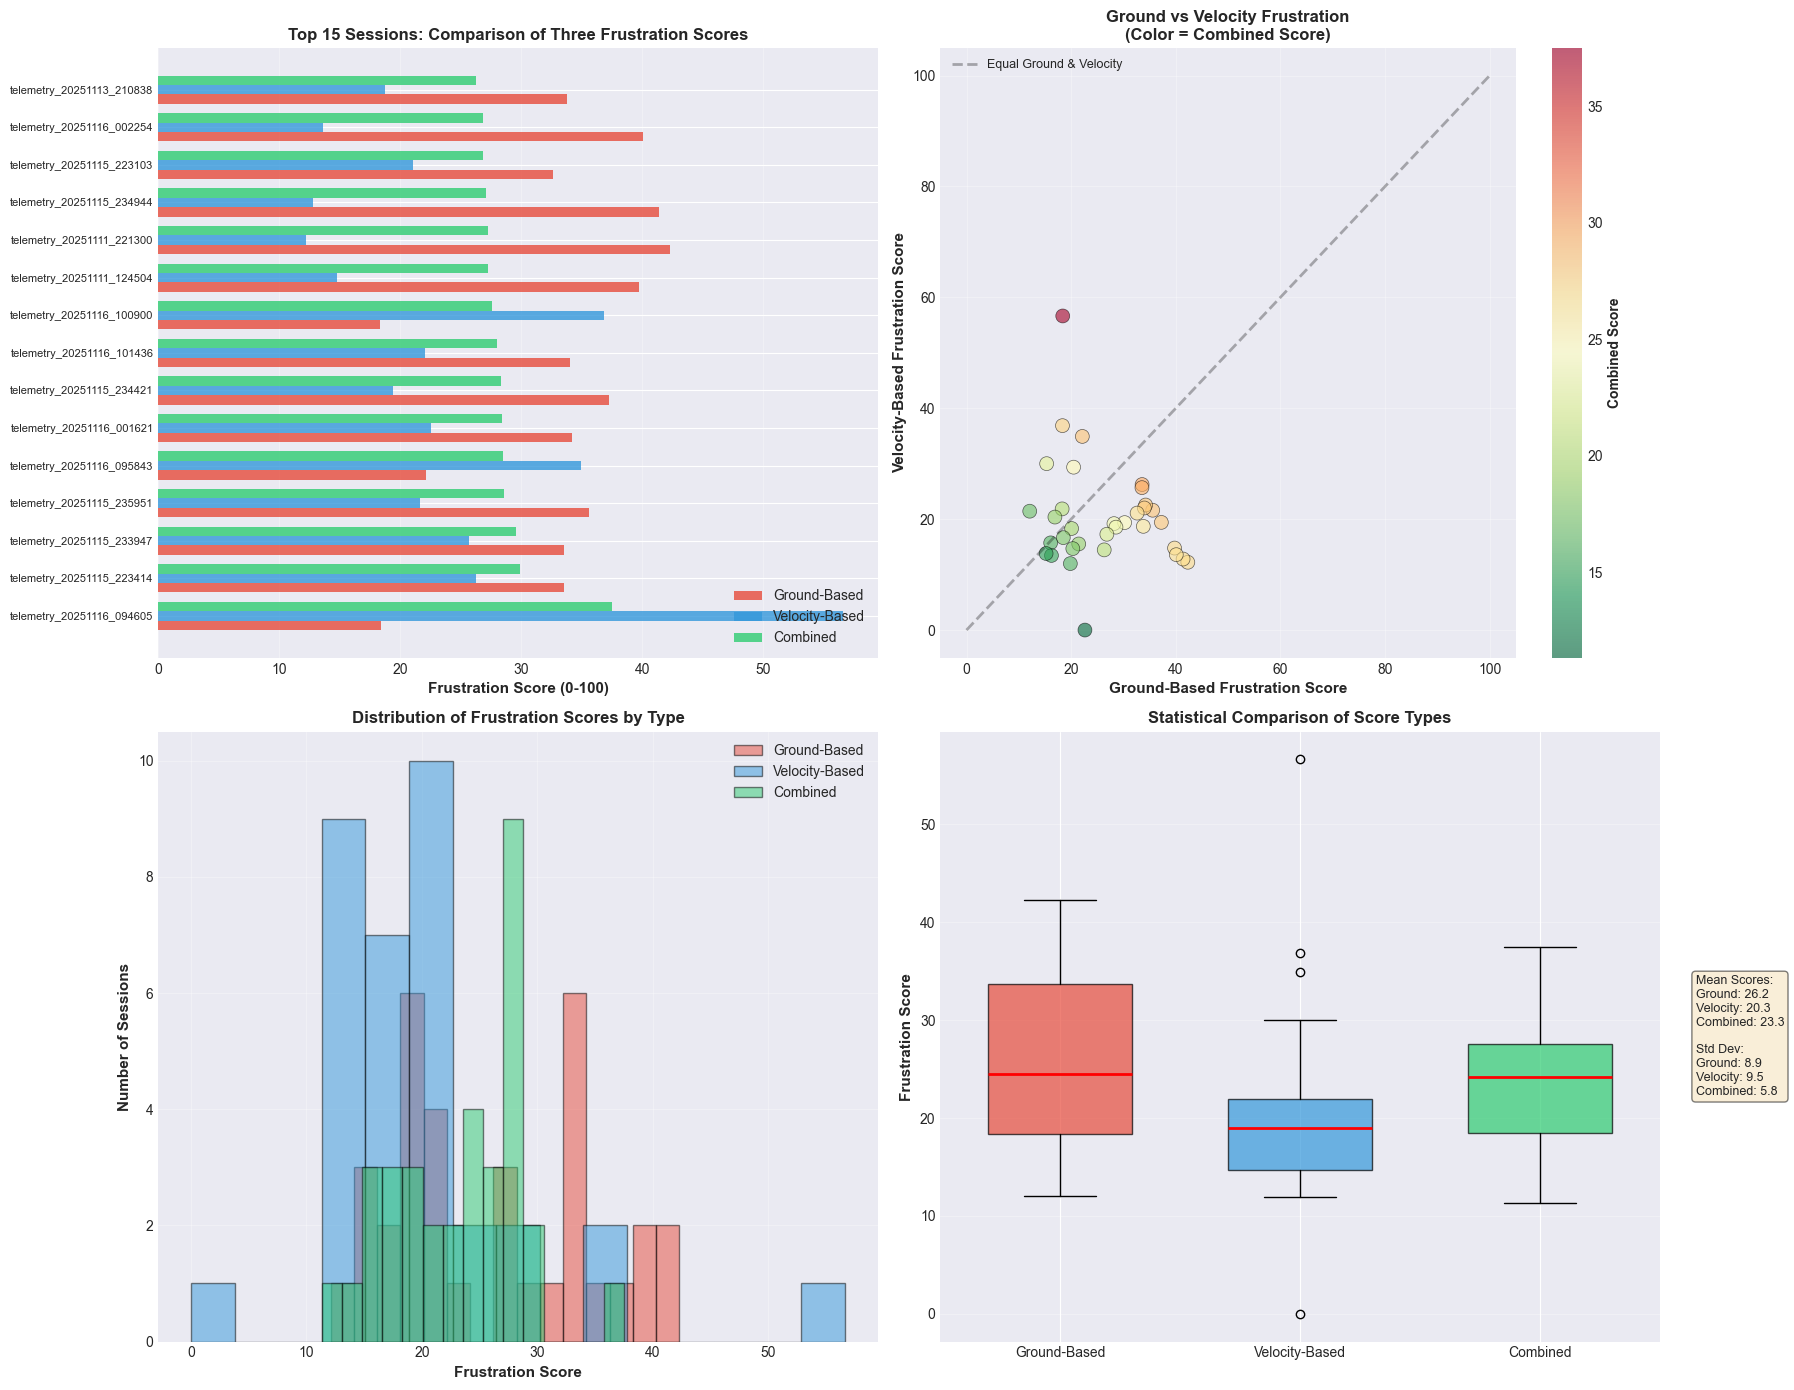

Chart saved as 'frustration_scores_comparison.png'


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Top 15 sessions for better visibility
top_n = 15
top_sessions = frustration_df.head(top_n)

# 1. Comparison of all three scores
ax1 = axes[0, 0]
x = np.arange(len(top_sessions))
width = 0.25

bars1 = ax1.barh(x - width, top_sessions['ground_frustration_100'], width, 
                 label='Ground-Based', color='#e74c3c', alpha=0.8)
bars2 = ax1.barh(x, top_sessions['velocity_frustration_100'], width, 
                 label='Velocity-Based', color='#3498db', alpha=0.8)
bars3 = ax1.barh(x + width, top_sessions['combined_frustration_100'], width, 
                 label='Combined', color='#2ecc71', alpha=0.8)

ax1.set_yticks(x)
ax1.set_yticklabels(top_sessions['session'], fontsize=8)
ax1.set_xlabel('Frustration Score (0-100)', fontsize=11, fontweight='bold')
ax1.set_title(f'Top {top_n} Sessions: Comparison of Three Frustration Scores', 
              fontsize=12, fontweight='bold')
ax1.legend(loc='lower right', fontsize=10)
ax1.grid(axis='x', alpha=0.3)

# 2. Scatter: Ground vs Velocity scores
ax2 = axes[0, 1]
scatter = ax2.scatter(frustration_df['ground_frustration_100'], 
                      frustration_df['velocity_frustration_100'],
                      c=frustration_df['combined_frustration_100'], 
                      s=100, cmap='RdYlGn_r', alpha=0.6, edgecolors='black', linewidth=0.5)
ax2.plot([0, 100], [0, 100], 'k--', alpha=0.3, linewidth=2, label='Equal Ground & Velocity')
ax2.set_xlabel('Ground-Based Frustration Score', fontsize=11, fontweight='bold')
ax2.set_ylabel('Velocity-Based Frustration Score', fontsize=11, fontweight='bold')
ax2.set_title('Ground vs Velocity Frustration\n(Color = Combined Score)', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=9)
ax2.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('Combined Score', fontsize=10, fontweight='bold')

# 3. Distribution of each score type
ax3 = axes[1, 0]
ax3.hist(frustration_df['ground_frustration_100'], bins=15, alpha=0.5, 
         label='Ground-Based', color='#e74c3c', edgecolor='black')
ax3.hist(frustration_df['velocity_frustration_100'], bins=15, alpha=0.5, 
         label='Velocity-Based', color='#3498db', edgecolor='black')
ax3.hist(frustration_df['combined_frustration_100'], bins=15, alpha=0.5, 
         label='Combined', color='#2ecc71', edgecolor='black')
ax3.set_xlabel('Frustration Score', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Sessions', fontsize=11, fontweight='bold')
ax3.set_title('Distribution of Frustration Scores by Type', fontsize=12, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(alpha=0.3)

# 4. Box plot comparison
ax4 = axes[1, 1]
box_data = [frustration_df['ground_frustration_100'], 
            frustration_df['velocity_frustration_100'], 
            frustration_df['combined_frustration_100']]
box = ax4.boxplot(box_data, labels=['Ground-Based', 'Velocity-Based', 'Combined'],
                  patch_artist=True, widths=0.6)

colors = ['#e74c3c', '#3498db', '#2ecc71']
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

for median in box['medians']:
    median.set_color('red')
    median.set_linewidth(2)

ax4.set_ylabel('Frustration Score', fontsize=11, fontweight='bold')
ax4.set_title('Statistical Comparison of Score Types', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add statistics text
stats_text = f'''Mean Scores:
Ground: {frustration_df["ground_frustration_100"].mean():.1f}
Velocity: {frustration_df["velocity_frustration_100"].mean():.1f}
Combined: {frustration_df["combined_frustration_100"].mean():.1f}

Std Dev:
Ground: {frustration_df["ground_frustration_100"].std():.1f}
Velocity: {frustration_df["velocity_frustration_100"].std():.1f}
Combined: {frustration_df["combined_frustration_100"].std():.1f}'''

ax4.text(1.05, 0.5, stats_text, transform=ax4.transAxes,
         fontsize=9, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('frustration_scores_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'frustration_scores_comparison.png'")

## 5. Visualizations for Report

### 5.1 Frustration Score by Session

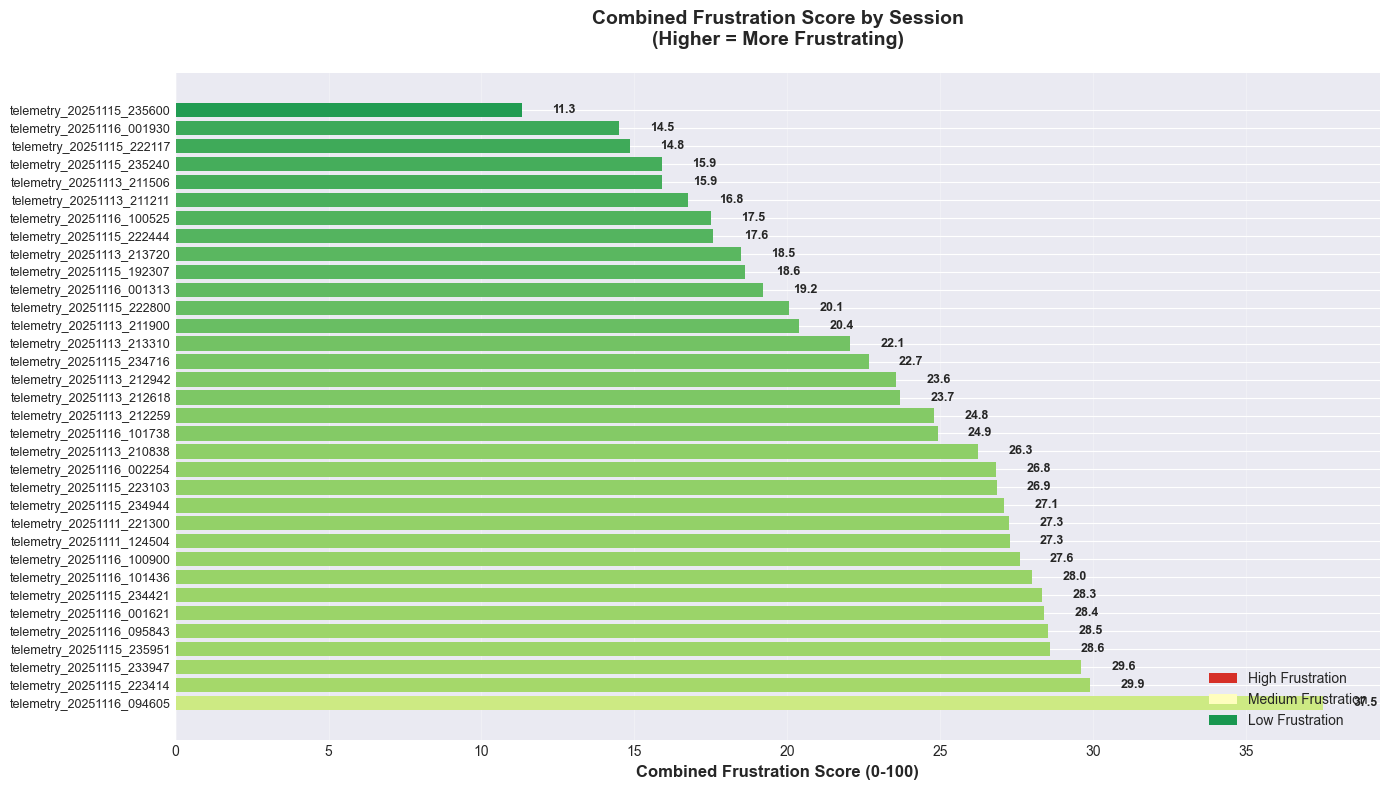

Chart saved as 'combined_frustration_score_by_session.png'


In [7]:
fig, ax = plt.subplots(figsize=(14, 8))

# Create bar plot using COMBINED frustration score
bars = ax.barh(range(len(frustration_df)), frustration_df['combined_frustration_100'], 
               color=plt.cm.RdYlGn_r(frustration_df['combined_frustration_100']/100))

# Customize plot
ax.set_yticks(range(len(frustration_df)))
ax.set_yticklabels(frustration_df['session'], fontsize=9)
ax.set_xlabel('Combined Frustration Score (0-100)', fontsize=12, fontweight='bold')
ax.set_title('Combined Frustration Score by Session\n(Higher = More Frustrating)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(frustration_df.iterrows()):
    ax.text(row['combined_frustration_100'] + 1, i, f"{row['combined_frustration_100']:.1f}", 
            va='center', fontsize=9, fontweight='bold')

# Add color legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=plt.cm.RdYlGn_r(0.9), label='High Frustration'),
    Patch(facecolor=plt.cm.RdYlGn_r(0.5), label='Medium Frustration'),
    Patch(facecolor=plt.cm.RdYlGn_r(0.1), label='Low Frustration')
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

plt.tight_layout()
plt.savefig('combined_frustration_score_by_session.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'combined_frustration_score_by_session.png'")

### 5.2 Frustration Components Breakdown

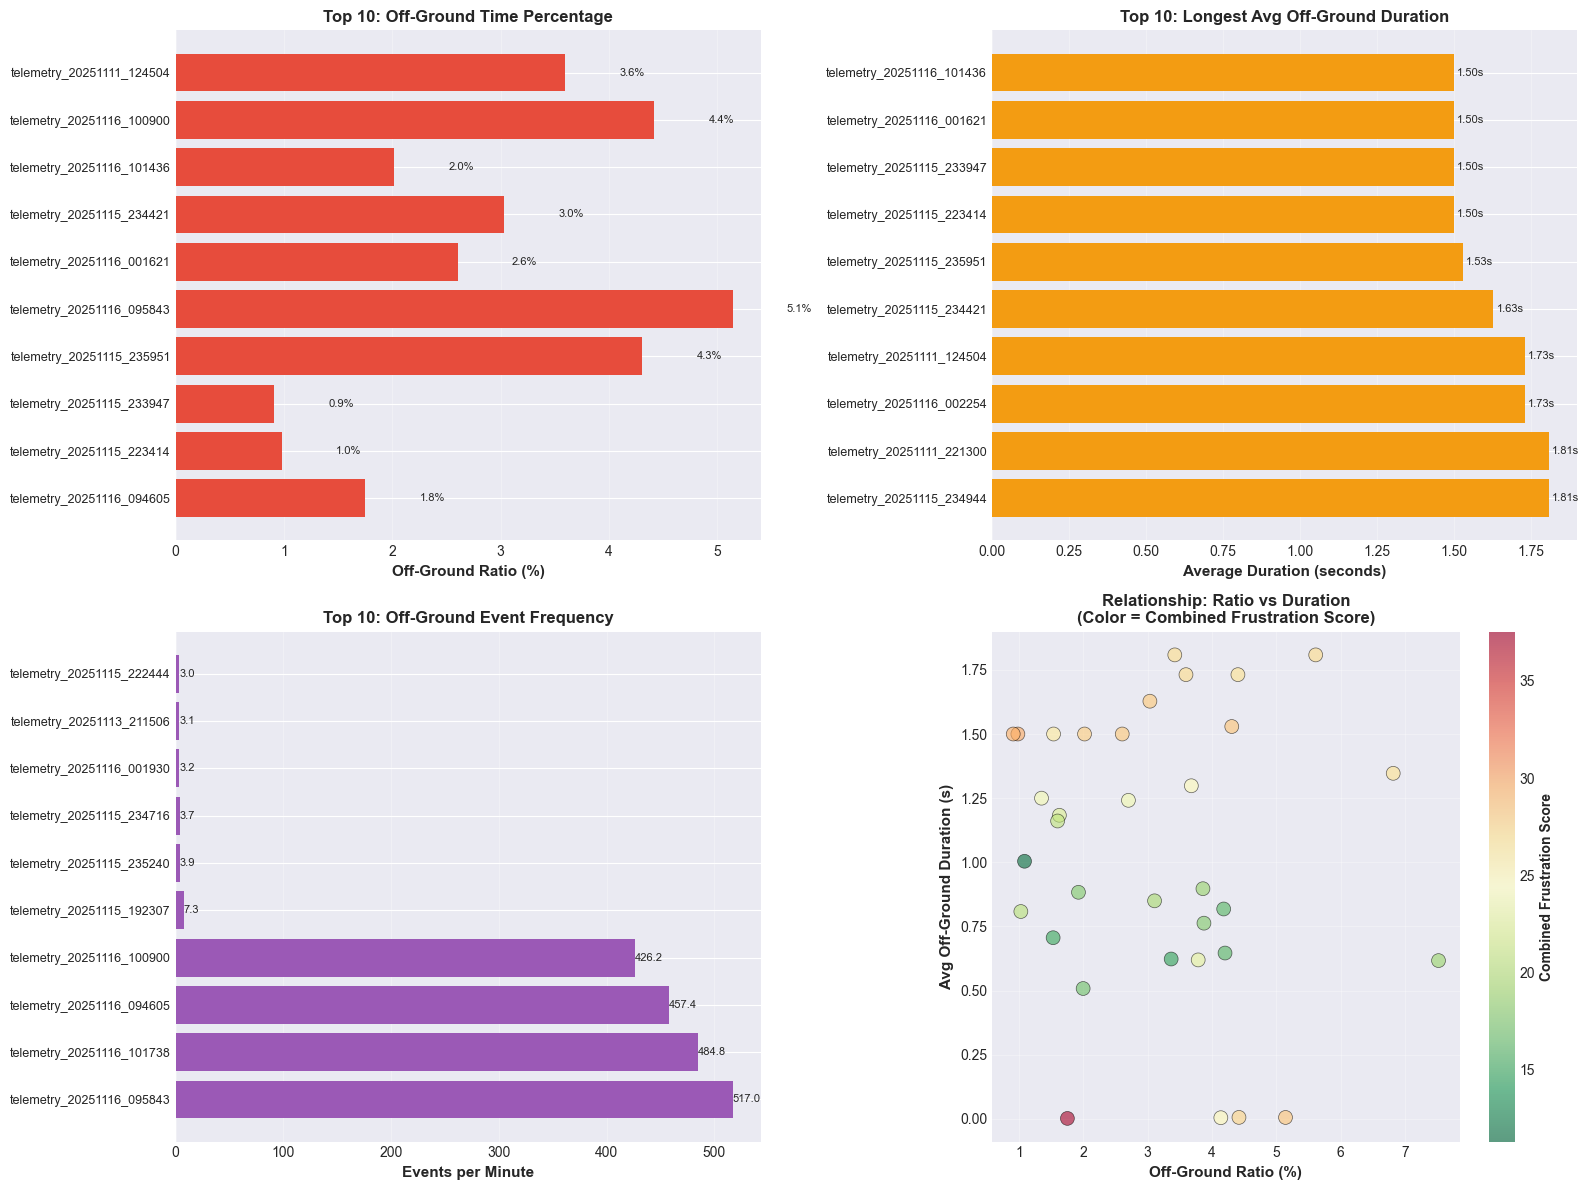

Chart saved as 'frustration_components_breakdown.png'


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Off-Ground Ratio
ax1 = axes[0, 0]
top_10 = frustration_df.head(10)
bars1 = ax1.barh(range(len(top_10)), top_10['off_ground_ratio'] * 100, color='#e74c3c')
ax1.set_yticks(range(len(top_10)))
ax1.set_yticklabels(top_10['session'], fontsize=9)
ax1.set_xlabel('Off-Ground Ratio (%)', fontsize=11, fontweight='bold')
ax1.set_title('Top 10: Off-Ground Time Percentage', fontsize=12, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(top_10.iterrows()):
    ax1.text(row['off_ground_ratio'] * 100 + 0.5, i, f"{row['off_ground_ratio']*100:.1f}%", 
             va='center', fontsize=8)

# 2. Average Off-Ground Duration
ax2 = axes[0, 1]
top_10_duration = frustration_df.nlargest(10, 'avg_off_ground_duration')
bars2 = ax2.barh(range(len(top_10_duration)), top_10_duration['avg_off_ground_duration'], color='#f39c12')
ax2.set_yticks(range(len(top_10_duration)))
ax2.set_yticklabels(top_10_duration['session'], fontsize=9)
ax2.set_xlabel('Average Duration (seconds)', fontsize=11, fontweight='bold')
ax2.set_title('Top 10: Longest Avg Off-Ground Duration', fontsize=12, fontweight='bold')
ax2.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(top_10_duration.iterrows()):
    ax2.text(row['avg_off_ground_duration'] + 0.01, i, f"{row['avg_off_ground_duration']:.2f}s", 
             va='center', fontsize=8)

# 3. Event Frequency
ax3 = axes[1, 0]
top_10_freq = frustration_df.nlargest(10, 'event_frequency')
bars3 = ax3.barh(range(len(top_10_freq)), top_10_freq['event_frequency'], color='#9b59b6')
ax3.set_yticks(range(len(top_10_freq)))
ax3.set_yticklabels(top_10_freq['session'], fontsize=9)
ax3.set_xlabel('Events per Minute', fontsize=11, fontweight='bold')
ax3.set_title('Top 10: Off-Ground Event Frequency', fontsize=12, fontweight='bold')
ax3.grid(axis='x', alpha=0.3)
for i, (idx, row) in enumerate(top_10_freq.iterrows()):
    ax3.text(row['event_frequency'] + 0.1, i, f"{row['event_frequency']:.1f}", 
             va='center', fontsize=8)

# 4. Scatter plot: Duration vs Ratio
ax4 = axes[1, 1]
scatter = ax4.scatter(frustration_df['off_ground_ratio'] * 100, 
                     frustration_df['avg_off_ground_duration'],
                     c=frustration_df['combined_frustration_100'], 
                     s=100, cmap='RdYlGn_r', alpha=0.6, edgecolors='black', linewidth=0.5)
ax4.set_xlabel('Off-Ground Ratio (%)', fontsize=11, fontweight='bold')
ax4.set_ylabel('Avg Off-Ground Duration (s)', fontsize=11, fontweight='bold')
ax4.set_title('Relationship: Ratio vs Duration\n(Color = Combined Frustration Score)', fontsize=12, fontweight='bold')
ax4.grid(alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax4)
cbar.set_label('Combined Frustration Score', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('frustration_components_breakdown.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'frustration_components_breakdown.png'")

### 5.3 Time Series: On-Ground Status for Most Frustrating Session

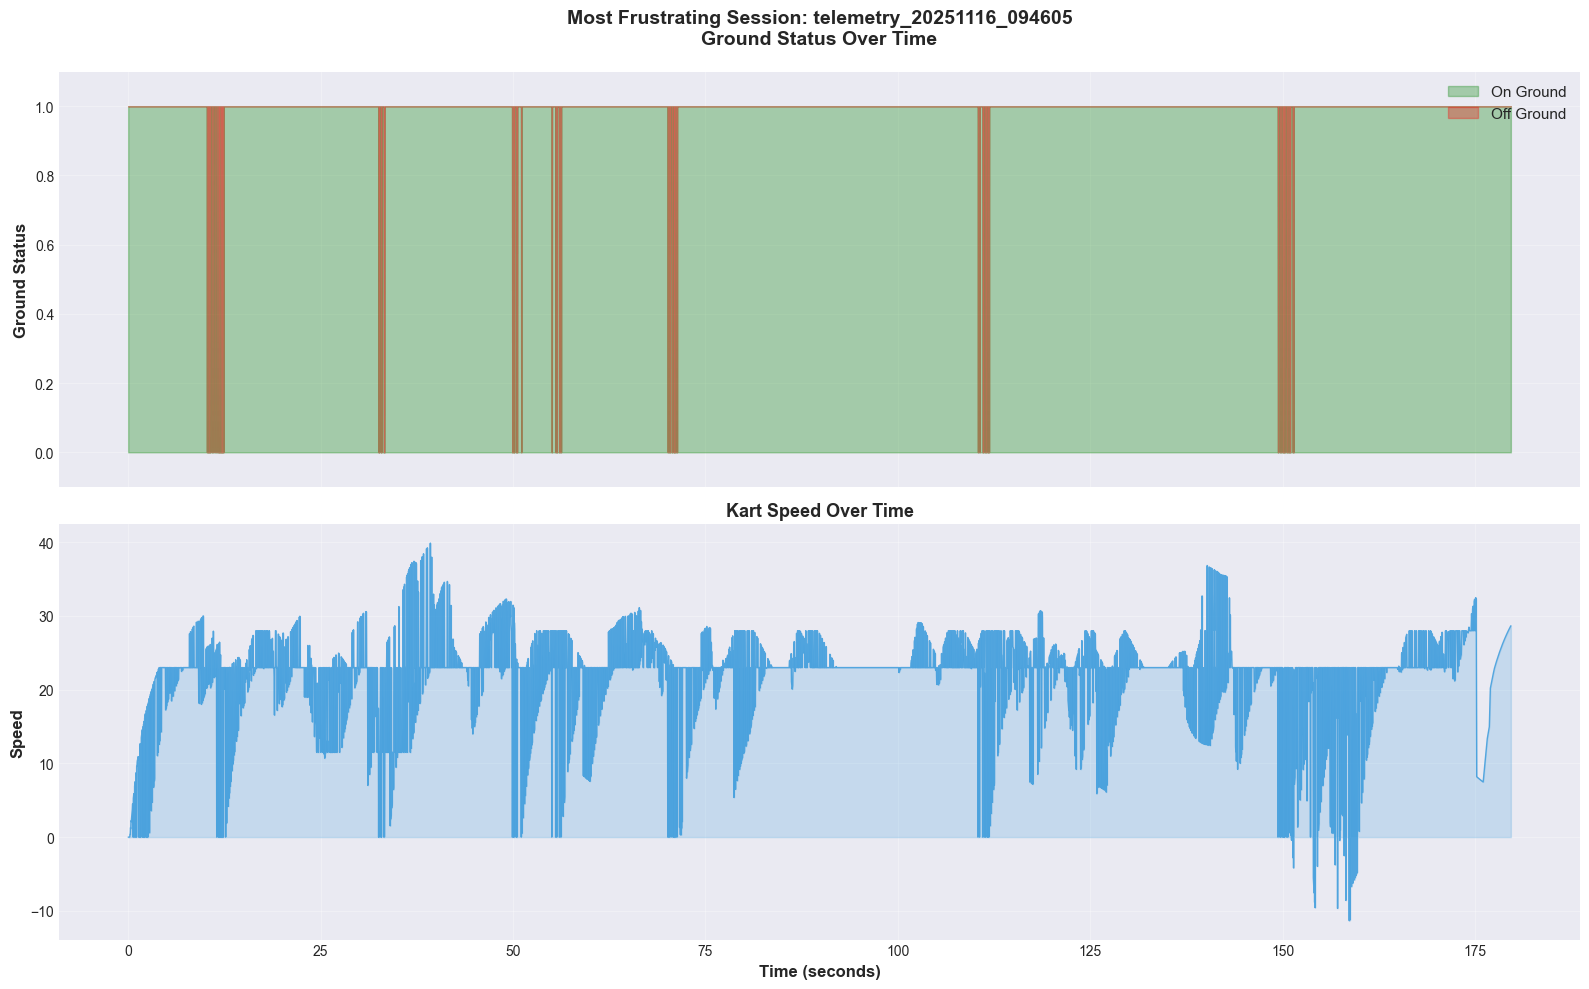

Chart saved as 'most_frustrating_session_timeline.png'

Most frustrating session: telemetry_20251116_094605
Combined frustration score: 37.52/100
Ground frustration: 18.40/100
Velocity frustration: 56.65/100


In [9]:
# Get the most frustrating session
most_frustrating = frustration_df.iloc[0]['session']
most_frustrating_df = combined_df[combined_df['session'] == most_frustrating].sort_values('time')

# Sample data if too large (for better visualization)
if len(most_frustrating_df) > 5000:
    sample_step = len(most_frustrating_df) // 5000
    plot_df = most_frustrating_df.iloc[::sample_step]
else:
    plot_df = most_frustrating_df

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Plot 1: On-ground status
ax1.fill_between(plot_df['time'], 0, plot_df['on_ground'], 
                 color='green', alpha=0.3, label='On Ground')
ax1.fill_between(plot_df['time'], plot_df['on_ground'], 1, 
                 color='red', alpha=0.3, label='Off Ground')
ax1.set_ylabel('Ground Status', fontsize=12, fontweight='bold')
ax1.set_title(f'Most Frustrating Session: {most_frustrating}\nGround Status Over Time', 
              fontsize=14, fontweight='bold', pad=20)
ax1.set_ylim(-0.1, 1.1)
ax1.legend(loc='upper right', fontsize=11)
ax1.grid(alpha=0.3)

# Plot 2: Speed
ax2.plot(plot_df['time'], plot_df['speed'], color='#3498db', linewidth=1, alpha=0.8)
ax2.set_xlabel('Time (seconds)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Speed', fontsize=12, fontweight='bold')
ax2.set_title('Kart Speed Over Time', fontsize=13, fontweight='bold')
ax2.grid(alpha=0.3)
ax2.fill_between(plot_df['time'], 0, plot_df['speed'], alpha=0.2, color='#3498db')

plt.tight_layout()
plt.savefig('most_frustrating_session_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Chart saved as 'most_frustrating_session_timeline.png'")
print(f"\nMost frustrating session: {most_frustrating}")
print(f"Combined frustration score: {frustration_df.iloc[0]['combined_frustration_100']:.2f}/100")
print(f"Ground frustration: {frustration_df.iloc[0]['ground_frustration_100']:.2f}/100")
print(f"Velocity frustration: {frustration_df.iloc[0]['velocity_frustration_100']:.2f}/100")

### 5.4 Distribution of Frustration Scores

/var/folders/_f/2sn94tkj58z3_mbw0nny1wsh0000gn/T/ipykernel_42696/876627.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax2.boxplot([frustration_df['combined_frustration_100']],


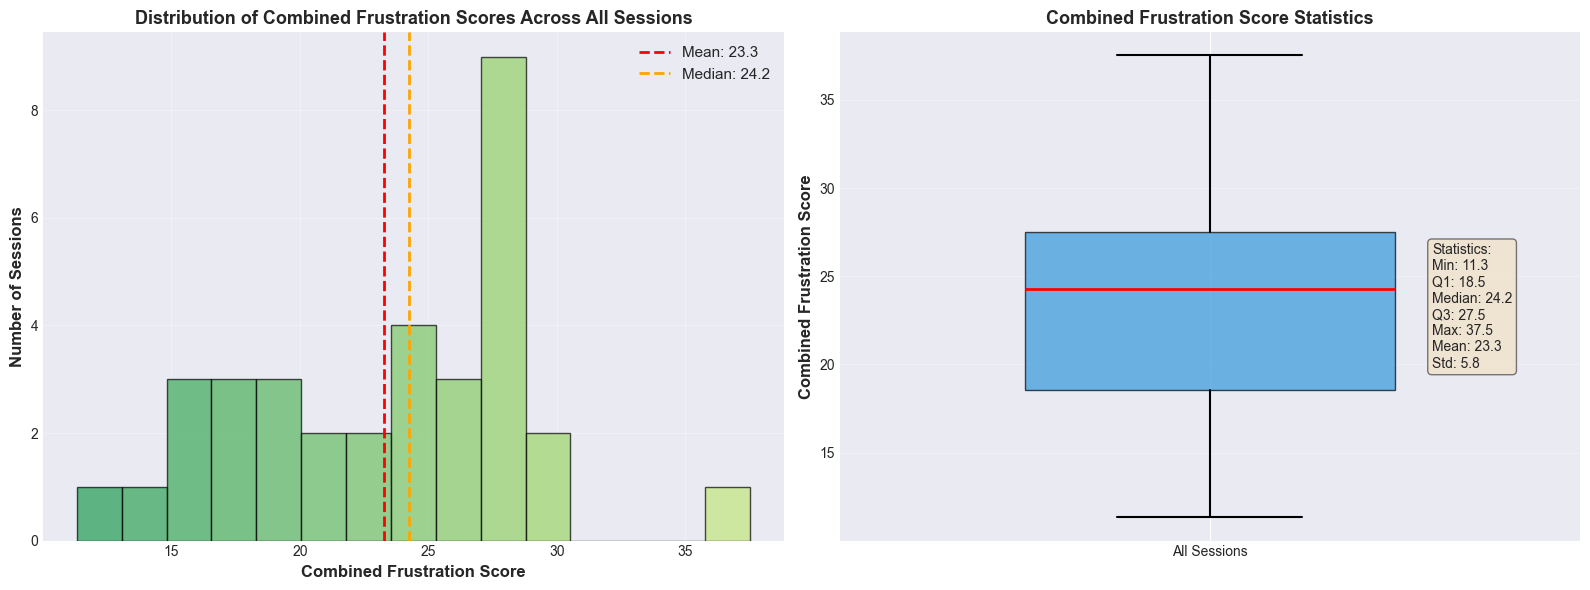

Chart saved as 'combined_frustration_distribution.png'


In [10]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram - using COMBINED frustration score
ax1 = axes[0]
n, bins, patches = ax1.hist(frustration_df['combined_frustration_100'], bins=15, 
                             edgecolor='black', alpha=0.7, color='#3498db')
# Color bars by value
for i, patch in enumerate(patches):
    patch.set_facecolor(plt.cm.RdYlGn_r(bins[i]/100))

ax1.set_xlabel('Combined Frustration Score', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Sessions', fontsize=12, fontweight='bold')
ax1.set_title('Distribution of Combined Frustration Scores Across All Sessions', 
              fontsize=13, fontweight='bold')
ax1.axvline(frustration_df['combined_frustration_100'].mean(), color='red', 
            linestyle='--', linewidth=2, label=f'Mean: {frustration_df["combined_frustration_100"].mean():.1f}')
ax1.axvline(frustration_df['combined_frustration_100'].median(), color='orange', 
            linestyle='--', linewidth=2, label=f'Median: {frustration_df["combined_frustration_100"].median():.1f}')
ax1.legend(fontsize=11)
ax1.grid(alpha=0.3)

# Box plot
ax2 = axes[1]
box = ax2.boxplot([frustration_df['combined_frustration_100']], 
                   labels=['All Sessions'], widths=0.5, patch_artist=True,
                   boxprops=dict(facecolor='#3498db', alpha=0.7),
                   medianprops=dict(color='red', linewidth=2),
                   whiskerprops=dict(linewidth=1.5),
                   capprops=dict(linewidth=1.5))

ax2.set_ylabel('Combined Frustration Score', fontsize=12, fontweight='bold')
ax2.set_title('Combined Frustration Score Statistics', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add statistics text
stats_text = f'''Statistics:
Min: {frustration_df["combined_frustration_100"].min():.1f}
Q1: {frustration_df["combined_frustration_100"].quantile(0.25):.1f}
Median: {frustration_df["combined_frustration_100"].median():.1f}
Q3: {frustration_df["combined_frustration_100"].quantile(0.75):.1f}
Max: {frustration_df["combined_frustration_100"].max():.1f}
Mean: {frustration_df["combined_frustration_100"].mean():.1f}
Std: {frustration_df["combined_frustration_100"].std():.1f}'''

ax2.text(1.3, frustration_df["combined_frustration_100"].mean(), stats_text,
         fontsize=10, verticalalignment='center',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('combined_frustration_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'combined_frustration_distribution.png'")

### 5.5 Frustration by Track (if available)

Average Frustration by Track:
                 track  combined_frustration_100_mean  \
0                abyss                          32.96   
1   cornfield_crossing                          26.68   
2             hacienda                          26.29   
5             scotland                          26.07   
4            sandtrack                          25.20   
6          snowtuxpeak                          19.35   
3  ravenbridge_mansion                          18.49   
7       volcano_island                          17.22   

   combined_frustration_100_std  combined_frustration_100_count  \
0                          6.45                               2   
1                          1.00                               5   
2                          2.06                               5   
5                          4.23                               4   
4                          4.77                               4   
6                          3.02                       

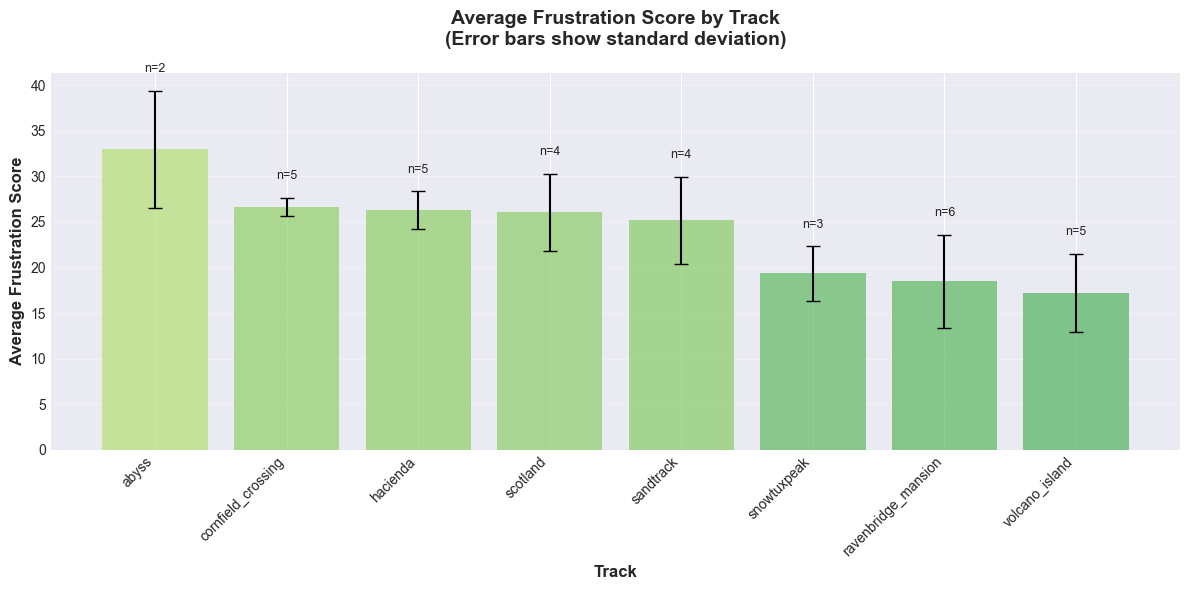

Chart saved as 'combined_frustration_by_track.png'


In [11]:
# Group by track and calculate average frustration - using COMBINED score
track_frustration = frustration_df.groupby('track').agg({
    'combined_frustration_100': ['mean', 'std', 'count'],
    'ground_frustration_100': 'mean',
    'velocity_frustration_100': 'mean',
    'off_ground_ratio': 'mean',
    'rapid_change_ratio': 'mean'
}).round(2)

track_frustration.columns = ['_'.join(col).strip() for col in track_frustration.columns.values]
track_frustration = track_frustration.reset_index()
track_frustration = track_frustration.sort_values('combined_frustration_100_mean', ascending=False)

print("Average Frustration by Track:")
print(track_frustration)

# Visualize
if len(track_frustration) > 1:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x_pos = range(len(track_frustration))
    bars = ax.bar(x_pos, track_frustration['combined_frustration_100_mean'], 
                  yerr=track_frustration['combined_frustration_100_std'],
                  capsize=5, alpha=0.7, 
                  color=plt.cm.RdYlGn_r(track_frustration['combined_frustration_100_mean']/100))
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(track_frustration['track'], rotation=45, ha='right')
    ax.set_ylabel('Average Frustration Score', fontsize=12, fontweight='bold')
    ax.set_xlabel('Track', fontsize=12, fontweight='bold')
    ax.set_title('Average Frustration Score by Track\n(Error bars show standard deviation)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='y', alpha=0.3)
    
    # Add count labels
    for i, (idx, row) in enumerate(track_frustration.iterrows()):
        ax.text(i, row['combined_frustration_100_mean'] + row['combined_frustration_100_std'] + 2,
                f"n={int(row['combined_frustration_100_count'])}", 
                ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('combined_frustration_by_track.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("Chart saved as 'combined_frustration_by_track.png'")
else:
    print(f"\nOnly one track found: {track_frustration['track'].iloc[0]}")

### 5.6 Correlation Heatmap

### 5.7 Advanced Track-Wise Analysis

Detailed analysis of each track's frustration patterns and identification of problematic sections.

DETAILED TRACK-WISE FRUSTRATION ANALYSIS
              track  combined_frustration_100_mean  combined_frustration_100_std  combined_frustration_100_min  combined_frustration_100_max  ground_frustration_100_mean  ground_frustration_100_std  velocity_frustration_100_mean  velocity_frustration_100_std  off_ground_ratio_mean  off_ground_ratio_std  rapid_change_ratio_mean  rapid_change_ratio_std  speed_std_mean  session_count
              abyss                          32.96                          6.45                         28.39                         37.52                        26.32                       11.20                          39.60                         24.11                   0.02                  0.01                     0.16                    0.22            6.16              2
 cornfield_crossing                          26.68                          1.00                         24.92                         27.28                        36.81                      

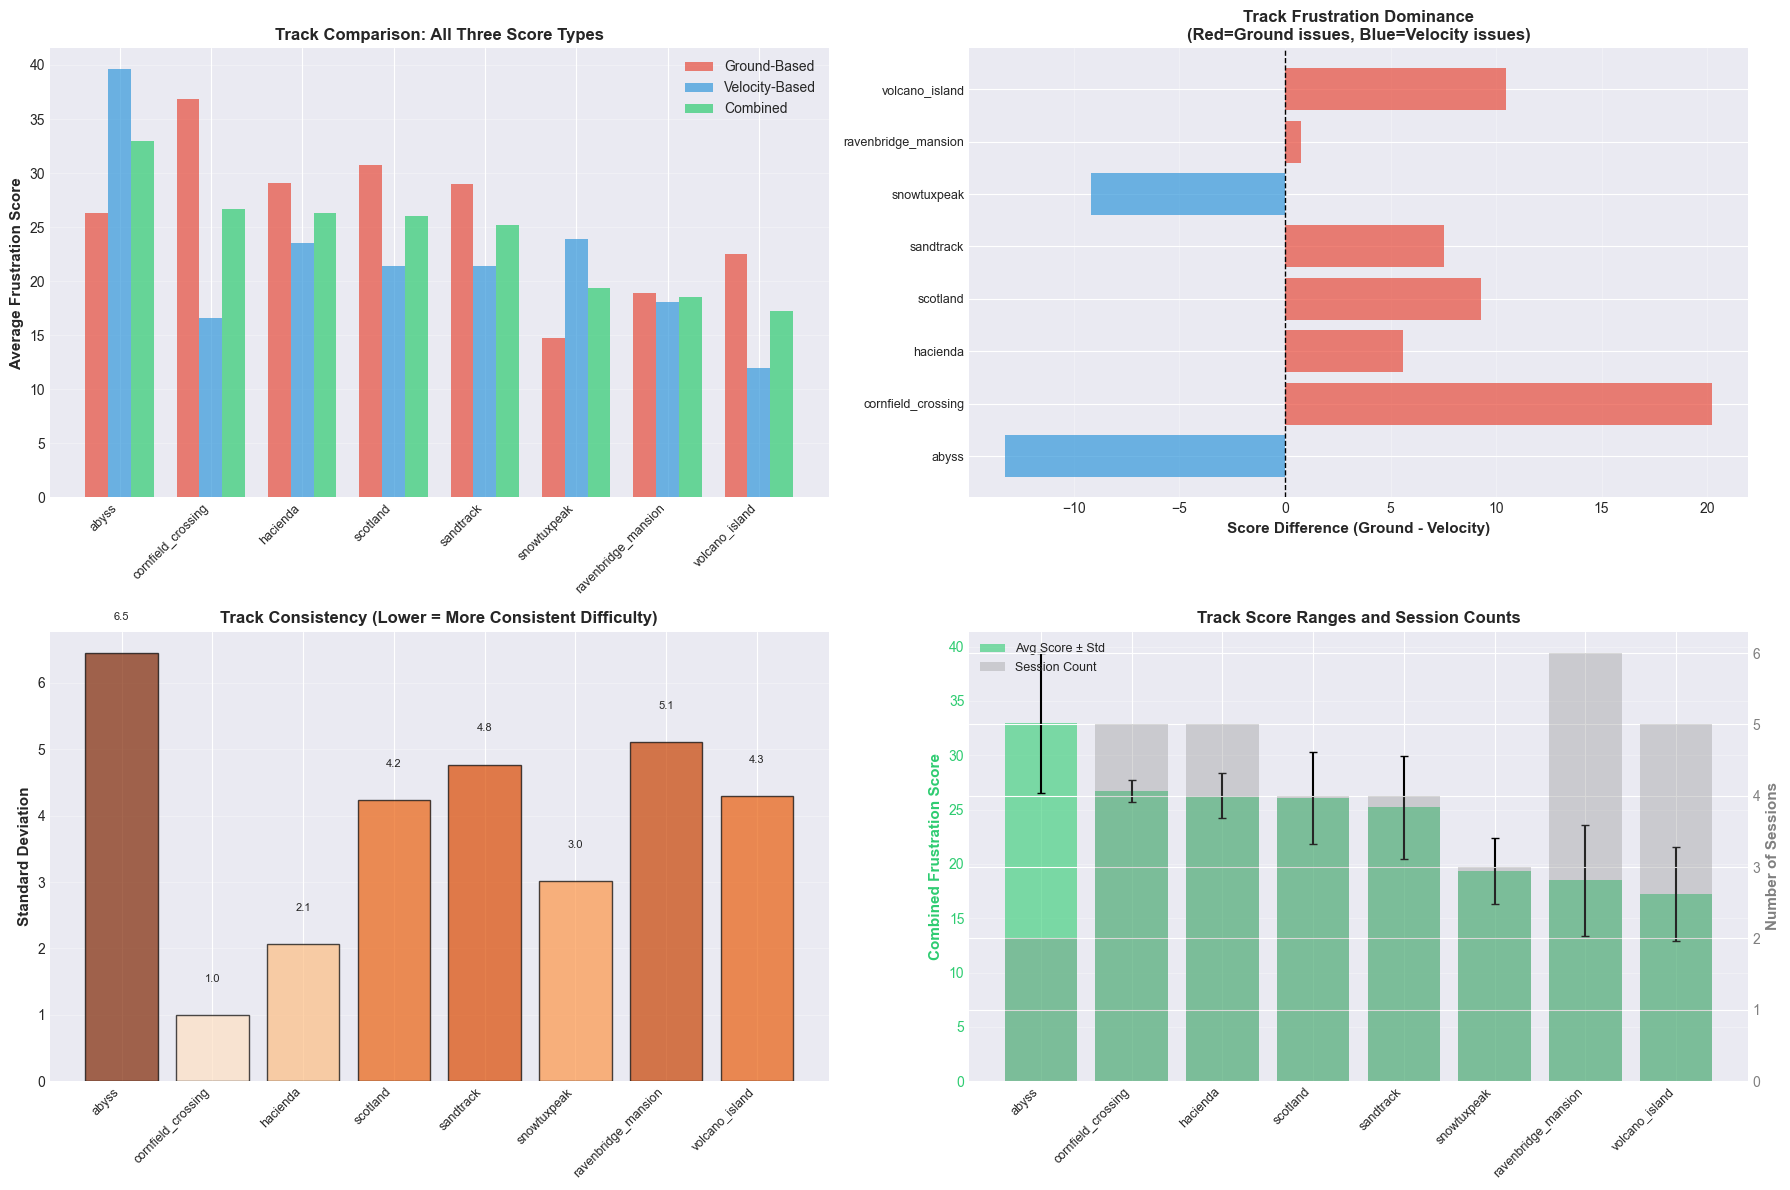


Chart saved as 'track_wise_detailed_analysis.png'


In [12]:
# Detailed track-wise comparison with all three scores
track_detailed = frustration_df.groupby('track').agg({
    'combined_frustration_100': ['mean', 'std', 'min', 'max'],
    'ground_frustration_100': ['mean', 'std'],
    'velocity_frustration_100': ['mean', 'std'],
    'off_ground_ratio': ['mean', 'std'],
    'rapid_change_ratio': ['mean', 'std'],
    'speed_std': 'mean',
    'session': 'count'
}).round(2)

track_detailed.columns = ['_'.join(col).strip() for col in track_detailed.columns.values]
track_detailed = track_detailed.reset_index()
track_detailed = track_detailed.sort_values('combined_frustration_100_mean', ascending=False)

print("=" * 100)
print("DETAILED TRACK-WISE FRUSTRATION ANALYSIS")
print("=" * 100)
print(track_detailed.to_string(index=False))
print("=" * 100)

# Visualize track comparison with all three score types
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Only tracks with sessions (exclude zero-session tracks)
track_with_data = track_detailed[track_detailed['session_count'] > 0].copy()

# 1. Comparison of all three score types by track
ax1 = axes[0, 0]
x = np.arange(len(track_with_data))
width = 0.25

bars1 = ax1.bar(x - width, track_with_data['ground_frustration_100_mean'], width,
               label='Ground-Based', color='#e74c3c', alpha=0.7)
bars2 = ax1.bar(x, track_with_data['velocity_frustration_100_mean'], width,
               label='Velocity-Based', color='#3498db', alpha=0.7)
bars3 = ax1.bar(x + width, track_with_data['combined_frustration_100_mean'], width,
               label='Combined', color='#2ecc71', alpha=0.7)

ax1.set_xticks(x)
ax1.set_xticklabels(track_with_data['track'], rotation=45, ha='right', fontsize=9)
ax1.set_ylabel('Average Frustration Score', fontsize=11, fontweight='bold')
ax1.set_title('Track Comparison: All Three Score Types', fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

# 2. Ground vs Velocity dominance by track
ax2 = axes[0, 1]
track_with_data['ground_velocity_diff'] = (track_with_data['ground_frustration_100_mean'] - 
                                            track_with_data['velocity_frustration_100_mean'])
colors = ['#e74c3c' if x > 0 else '#3498db' for x in track_with_data['ground_velocity_diff']]
bars = ax2.barh(range(len(track_with_data)), track_with_data['ground_velocity_diff'], color=colors, alpha=0.7)
ax2.set_yticks(range(len(track_with_data)))
ax2.set_yticklabels(track_with_data['track'], fontsize=9)
ax2.set_xlabel('Score Difference (Ground - Velocity)', fontsize=11, fontweight='bold')
ax2.set_title('Track Frustration Dominance\n(Red=Ground issues, Blue=Velocity issues)', 
              fontsize=12, fontweight='bold')
ax2.axvline(0, color='black', linewidth=1, linestyle='--')
ax2.grid(axis='x', alpha=0.3)

# 3. Consistency analysis (standard deviation)
ax3 = axes[1, 0]
x_pos = np.arange(len(track_with_data))
bars = ax3.bar(x_pos, track_with_data['combined_frustration_100_std'], 
               color=plt.cm.Oranges(track_with_data['combined_frustration_100_std']/
                                    track_with_data['combined_frustration_100_std'].max()),
               alpha=0.7, edgecolor='black', linewidth=1)
ax3.set_xticks(x_pos)
ax3.set_xticklabels(track_with_data['track'], rotation=45, ha='right', fontsize=9)
ax3.set_ylabel('Standard Deviation', fontsize=11, fontweight='bold')
ax3.set_title('Track Consistency (Lower = More Consistent Difficulty)', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)

# Add value labels
for i, (idx, row) in enumerate(track_with_data.iterrows()):
    ax3.text(i, row['combined_frustration_100_std'] + 0.5, 
             f"{row['combined_frustration_100_std']:.1f}", 
             ha='center', fontsize=8)

# 4. Session count and score range by track
ax4 = axes[1, 1]
x_pos = np.arange(len(track_with_data))
# Plot bars for session count
ax4_twin = ax4.twinx()
bars1 = ax4.bar(x_pos, track_with_data['combined_frustration_100_mean'], 
                yerr=track_with_data['combined_frustration_100_std'],
                capsize=3, alpha=0.6, color='#2ecc71', label='Avg Score ± Std')
bars2 = ax4_twin.bar(x_pos, track_with_data['session_count'], 
                     alpha=0.3, color='gray', label='Session Count')

ax4.set_xticks(x_pos)
ax4.set_xticklabels(track_with_data['track'], rotation=45, ha='right', fontsize=9)
ax4.set_ylabel('Combined Frustration Score', fontsize=11, fontweight='bold', color='#2ecc71')
ax4_twin.set_ylabel('Number of Sessions', fontsize=11, fontweight='bold', color='gray')
ax4.set_title('Track Score Ranges and Session Counts', fontsize=12, fontweight='bold')
ax4.tick_params(axis='y', labelcolor='#2ecc71')
ax4_twin.tick_params(axis='y', labelcolor='gray')
ax4.grid(axis='y', alpha=0.3)

# Add legends
lines1, labels1 = ax4.get_legend_handles_labels()
lines2, labels2 = ax4_twin.get_legend_handles_labels()
ax4.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('track_wise_detailed_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nChart saved as 'track_wise_detailed_analysis.png'")

### 5.8 Identify Most Frustrating Track Sections

Spatial analysis to pinpoint specific sections/coordinates where players experience the most frustration.

In [13]:
def identify_frustrating_sections(track_name, combined_df, grid_size=5):
    """
    Identify frustrating sections of a track by dividing it into spatial grids.
    
    Parameters:
    - track_name: Name of the track to analyze
    - combined_df: DataFrame with all session data
    - grid_size: Size of spatial grid divisions
    """
    # Filter data for this track
    track_data = combined_df[combined_df['track'] == track_name].copy()
    
    if len(track_data) == 0:
        return None, None
    
    # Create spatial grid bins
    track_data['x_bin'] = pd.cut(track_data['x'], bins=grid_size, labels=False)
    track_data['z_bin'] = pd.cut(track_data['z'], bins=grid_size, labels=False)
    
    # Calculate frustration indicators per grid cell
    grid_frustration = track_data.groupby(['x_bin', 'z_bin']).agg({
        'on_ground': lambda x: 1 - x.mean(),  # Off-ground ratio
        'speed': ['mean', 'std'],
        'time': 'count'
    }).reset_index()
    
    grid_frustration.columns = ['x_bin', 'z_bin', 'off_ground_ratio', 'avg_speed', 'speed_std', 'point_count']
    
    # Calculate velocity changes per grid
    track_data['velocity_change'] = track_data.groupby(['x_bin', 'z_bin'])['speed'].diff().abs()
    velocity_grid = track_data.groupby(['x_bin', 'z_bin'])['velocity_change'].mean().reset_index()
    velocity_grid.columns = ['x_bin', 'z_bin', 'avg_velocity_change']
    
    # Merge frustration indicators
    grid_frustration = grid_frustration.merge(velocity_grid, on=['x_bin', 'z_bin'], how='left')
    
    # Calculate composite frustration score for each grid cell
    # Normalize metrics
    grid_frustration['norm_off_ground'] = grid_frustration['off_ground_ratio']
    grid_frustration['norm_velocity_change'] = ((grid_frustration['avg_velocity_change'] - 
                                                  grid_frustration['avg_velocity_change'].min()) / 
                                                 (grid_frustration['avg_velocity_change'].max() - 
                                                  grid_frustration['avg_velocity_change'].min() + 1e-10))
    grid_frustration['norm_speed_std'] = ((grid_frustration['speed_std'] - 
                                           grid_frustration['speed_std'].min()) / 
                                          (grid_frustration['speed_std'].max() - 
                                           grid_frustration['speed_std'].min() + 1e-10))
    
    # Composite score (weight by data density)
    grid_frustration['section_frustration'] = (0.4 * grid_frustration['norm_off_ground'] + 
                                                0.3 * grid_frustration['norm_velocity_change'] + 
                                                0.3 * grid_frustration['norm_speed_std'])
    
    # Weight by point density (more reliable where we have more data)
    min_points = 10  # Minimum points to consider reliable
    grid_frustration['reliability'] = np.minimum(grid_frustration['point_count'] / min_points, 1.0)
    grid_frustration['weighted_frustration'] = (grid_frustration['section_frustration'] * 
                                                 grid_frustration['reliability'])
    
    return grid_frustration, track_data

# Analyze each track with sufficient data
tracks_to_analyze = frustration_df.groupby('track')['session'].count()
tracks_to_analyze = tracks_to_analyze[tracks_to_analyze > 0].index.tolist()

print("=" * 100)
print("ANALYZING FRUSTRATING TRACK SECTIONS")
print("=" * 100)

track_section_data = {}
for track in tracks_to_analyze:
    grid_data, track_data = identify_frustrating_sections(track, combined_df, grid_size=10)
    if grid_data is not None:
        track_section_data[track] = {'grid': grid_data, 'raw': track_data}
        
        # Get top 5 most frustrating sections
        top_sections = grid_data.nlargest(5, 'weighted_frustration')
        
        print(f"\n{track.upper()}:")
        print(f"  Total data points: {len(track_data)}")
        print(f"  Grid cells analyzed: {len(grid_data)}")
        print(f"  Top 3 most frustrating sections:")
        for idx, row in top_sections.head(3).iterrows():
            print(f"    - Grid ({row['x_bin']}, {row['z_bin']}): "
                  f"Frustration={row['weighted_frustration']:.2f}, "
                  f"Off-ground={row['off_ground_ratio']*100:.1f}%, "
                  f"Avg Speed={row['avg_speed']:.1f}")

print("\n" + "=" * 100)

ANALYZING FRUSTRATING TRACK SECTIONS

ABYSS:
  Total data points: 104434
  Grid cells analyzed: 47
  Top 3 most frustrating sections:
    - Grid (7.0, 7.0): Frustration=0.52, Off-ground=0.0%, Avg Speed=13.8
    - Grid (4.0, 3.0): Frustration=0.50, Off-ground=8.5%, Avg Speed=13.0
    - Grid (1.0, 7.0): Frustration=0.44, Off-ground=12.7%, Avg Speed=19.6

CORNFIELD_CROSSING:
  Total data points: 105033
  Grid cells analyzed: 41
  Top 3 most frustrating sections:
    - Grid (5.0, 3.0): Frustration=0.86, Off-ground=100.0%, Avg Speed=26.7
    - Grid (6.0, 4.0): Frustration=0.62, Off-ground=100.0%, Avg Speed=23.3
    - Grid (5.0, 4.0): Frustration=0.39, Off-ground=62.0%, Avg Speed=24.5

HACIENDA:
  Total data points: 115097
  Grid cells analyzed: 40
  Top 3 most frustrating sections:
    - Grid (3.0, 7.0): Frustration=0.78, Off-ground=61.3%, Avg Speed=21.2
    - Grid (0.0, 1.0): Frustration=0.72, Off-ground=33.6%, Avg Speed=14.0
    - Grid (6.0, 7.0): Frustration=0.41, Off-ground=11.2%, Avg S

### 5.9 Visualize Frustrating Track Sections

Heatmaps showing where on each track players experience the most difficulty.

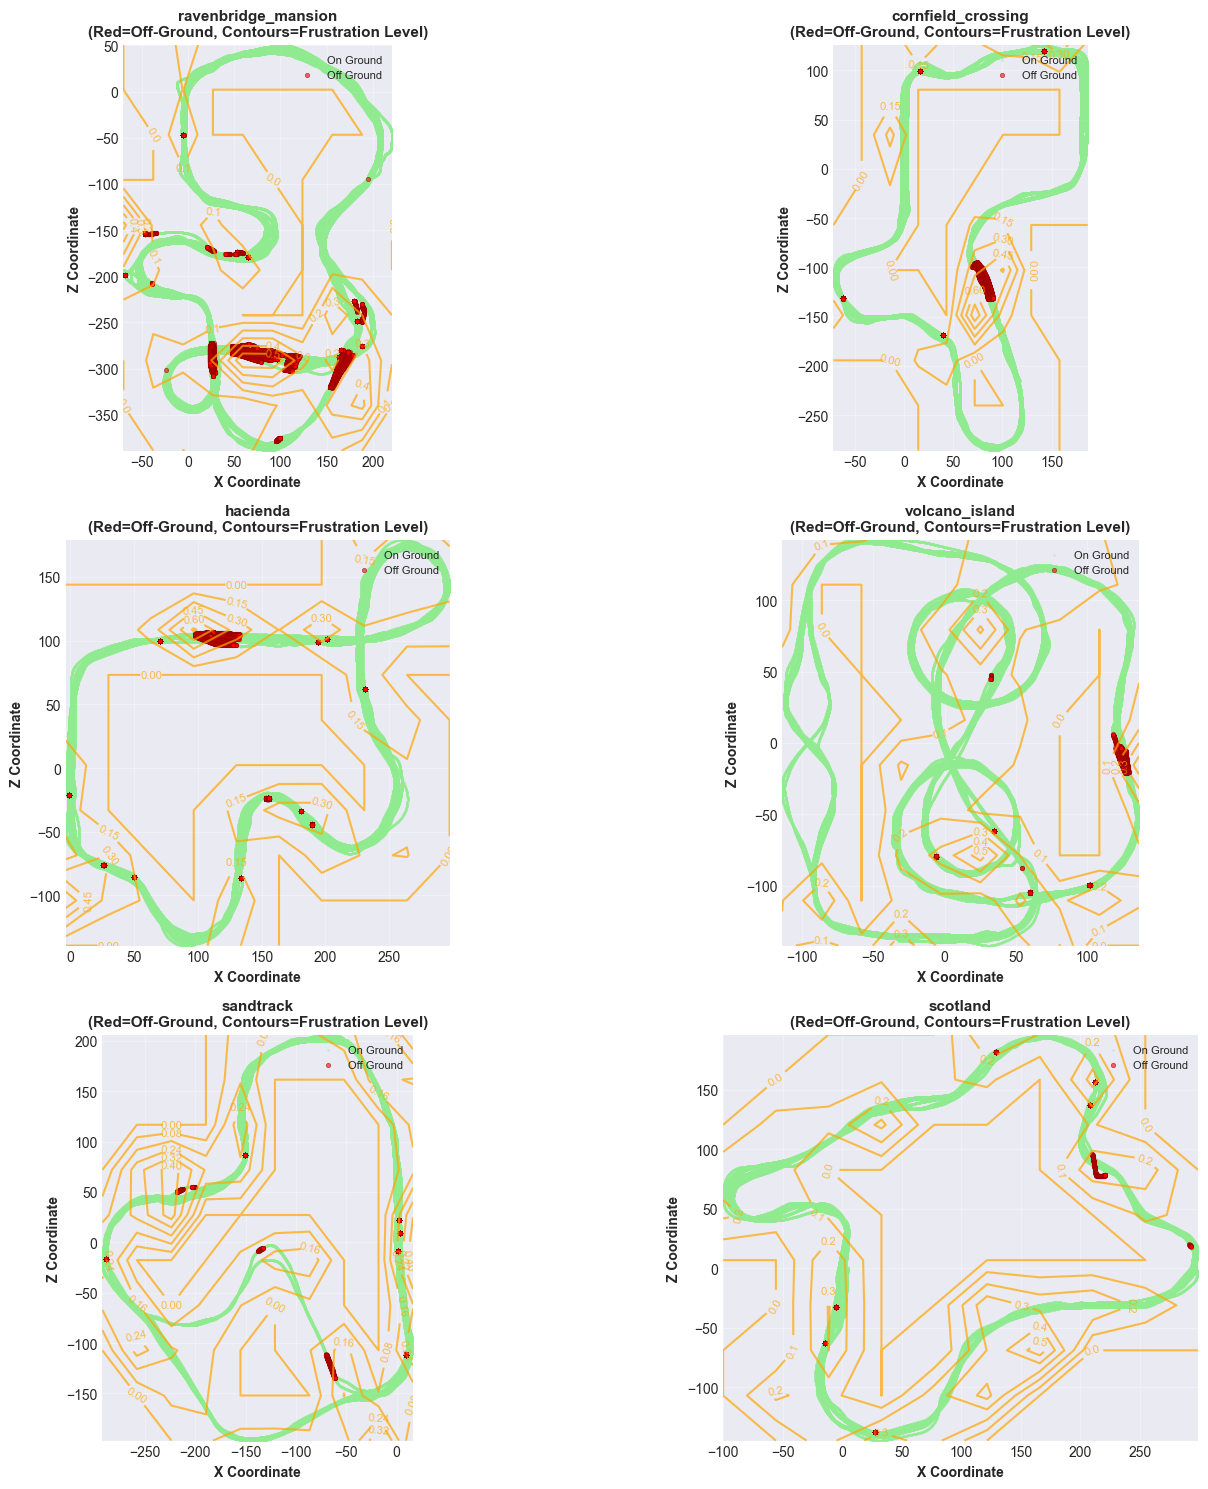

Chart saved as 'track_frustration_heatmaps.png'


In [14]:
# Visualize frustrating sections for tracks with sufficient data
tracks_with_data = [track for track in track_section_data.keys() if len(track_section_data[track]['raw']) > 100]

# Limit to top 6 most played tracks for visualization
top_tracks = frustration_df.groupby('track').size().nlargest(6).index.tolist()
tracks_to_plot = [t for t in top_tracks if t in tracks_with_data][:6]

if len(tracks_to_plot) > 0:
    n_tracks = len(tracks_to_plot)
    n_cols = 2
    n_rows = (n_tracks + 1) // 2
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for idx, track in enumerate(tracks_to_plot):
        row = idx // n_cols
        col = idx % n_cols
        ax = axes[row, col]
        
        track_data = track_section_data[track]['raw']
        
        # Create scatter plot with frustration indicators
        # Color by off-ground status and size by speed variance
        off_ground_mask = track_data['on_ground'] == 0
        
        # Plot on-ground points
        on_ground = track_data[~off_ground_mask]
        if len(on_ground) > 0:
            scatter1 = ax.scatter(on_ground['x'], on_ground['z'], 
                                 c='lightgreen', s=1, alpha=0.3, label='On Ground')
        
        # Plot off-ground points (frustration indicators)
        off_ground = track_data[off_ground_mask]
        if len(off_ground) > 0:
            scatter2 = ax.scatter(off_ground['x'], off_ground['z'], 
                                 c='red', s=10, alpha=0.6, label='Off Ground', 
                                 edgecolors='darkred', linewidth=0.5)
        
        # Overlay heatmap of frustration
        grid_data = track_section_data[track]['grid']
        
        # Create pivot table for heatmap
        pivot_frustration = grid_data.pivot_table(
            values='weighted_frustration', 
            index='z_bin', 
            columns='x_bin', 
            fill_value=0
        )
        
        # Overlay contour plot
        if len(pivot_frustration) > 1 and len(pivot_frustration.columns) > 1:
            # Get actual coordinate ranges
            x_range = track_data['x'].quantile([0, 1]).values
            z_range = track_data['z'].quantile([0, 1]).values
            
            # Create meshgrid
            x_coords = np.linspace(x_range[0], x_range[1], pivot_frustration.shape[1])
            z_coords = np.linspace(z_range[0], z_range[1], pivot_frustration.shape[0])
            X, Z = np.meshgrid(x_coords, z_coords)
            
            # Plot contours
            contours = ax.contour(X, Z, pivot_frustration.values, 
                                 levels=5, colors='orange', linewidths=1.5, alpha=0.7)
            ax.clabel(contours, inline=True, fontsize=8)
        
        ax.set_xlabel('X Coordinate', fontsize=10, fontweight='bold')
        ax.set_ylabel('Z Coordinate', fontsize=10, fontweight='bold')
        ax.set_title(f'{track}\n(Red=Off-Ground, Contours=Frustration Level)', 
                    fontsize=11, fontweight='bold')
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    # Hide unused subplots
    for idx in range(len(tracks_to_plot), n_rows * n_cols):
        row = idx // n_cols
        col = idx % n_cols
        axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.savefig('track_frustration_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Chart saved as 'track_frustration_heatmaps.png'")
else:
    print("Not enough track data for spatial visualization")

### 5.10 Track Performance Profiles

Detailed performance breakdown for each track showing patterns across sessions.

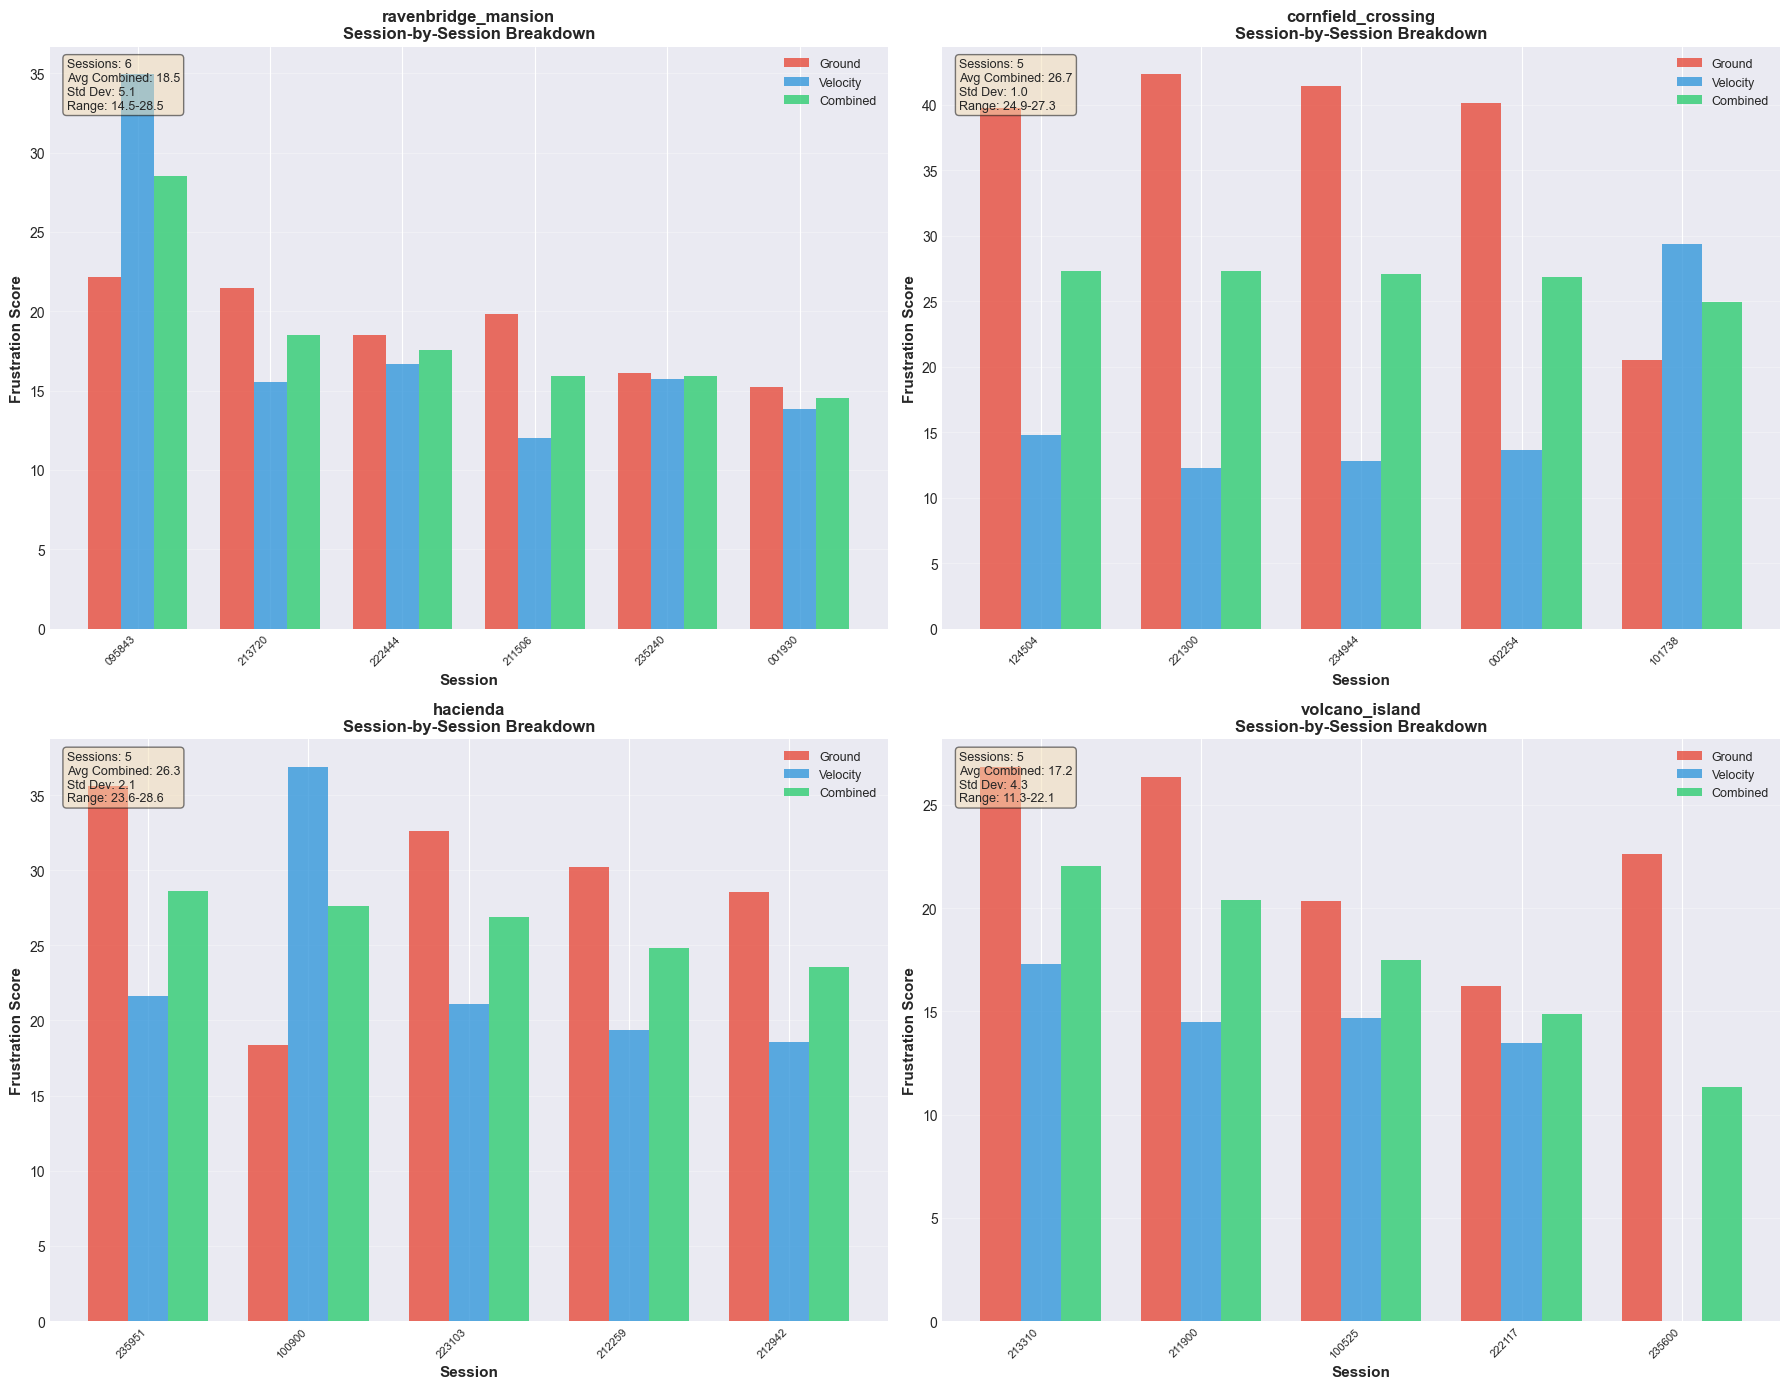

Chart saved as 'track_session_profiles.png'


In [15]:
# Create detailed profile for each track
tracks_with_multiple_sessions = frustration_df.groupby('track').filter(lambda x: len(x) > 1)['track'].unique()

if len(tracks_with_multiple_sessions) > 0:
    # Select top 4 tracks by session count
    top_analyzed_tracks = (frustration_df[frustration_df['track'].isin(tracks_with_multiple_sessions)]
                          .groupby('track').size().nlargest(4).index.tolist())
    
    fig, axes = plt.subplots(2, 2, figsize=(18, 14))
    axes = axes.flatten()
    
    for idx, track in enumerate(top_analyzed_tracks[:4]):
        ax = axes[idx]
        track_sessions = frustration_df[frustration_df['track'] == track].copy()
        track_sessions = track_sessions.sort_values('combined_frustration_100', ascending=False)
        
        # Create grouped bar chart for each session on this track
        x = np.arange(len(track_sessions))
        width = 0.25
        
        bars1 = ax.bar(x - width, track_sessions['ground_frustration_100'], width,
                      label='Ground', color='#e74c3c', alpha=0.8)
        bars2 = ax.bar(x, track_sessions['velocity_frustration_100'], width,
                      label='Velocity', color='#3498db', alpha=0.8)
        bars3 = ax.bar(x + width, track_sessions['combined_frustration_100'], width,
                      label='Combined', color='#2ecc71', alpha=0.8)
        
        # Customize
        ax.set_xticks(x)
        session_labels = [s.split('_')[-1] for s in track_sessions['session']]  # Extract timestamp
        ax.set_xticklabels(session_labels, rotation=45, ha='right', fontsize=8)
        ax.set_ylabel('Frustration Score', fontsize=11, fontweight='bold')
        ax.set_xlabel('Session', fontsize=11, fontweight='bold')
        ax.set_title(f'{track}\nSession-by-Session Breakdown', 
                    fontsize=12, fontweight='bold')
        ax.legend(fontsize=9)
        ax.grid(axis='y', alpha=0.3)
        
        # Add summary statistics box
        stats_text = (f'Sessions: {len(track_sessions)}\n'
                     f'Avg Combined: {track_sessions["combined_frustration_100"].mean():.1f}\n'
                     f'Std Dev: {track_sessions["combined_frustration_100"].std():.1f}\n'
                     f'Range: {track_sessions["combined_frustration_100"].min():.1f}-'
                     f'{track_sessions["combined_frustration_100"].max():.1f}')
        ax.text(0.02, 0.98, stats_text, transform=ax.transAxes,
               fontsize=9, verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Hide unused subplots
    for idx in range(len(top_analyzed_tracks), 4):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig('track_session_profiles.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Chart saved as 'track_session_profiles.png'")
else:
    print("Not enough multi-session tracks for profile analysis")

### 5.11 Export Track Analysis Data

In [16]:
# Export detailed track analysis
track_detailed.to_csv('track_wise_detailed_analysis.csv', index=False)
print("✓ Track-wise detailed analysis saved to 'track_wise_detailed_analysis.csv'")

# Export frustrating sections for each track
frustrating_sections_export = []
for track, data in track_section_data.items():
    grid_data = data['grid']
    top_sections = grid_data.nlargest(10, 'weighted_frustration')
    
    for idx, row in top_sections.iterrows():
        frustrating_sections_export.append({
            'track': track,
            'x_bin': row['x_bin'],
            'z_bin': row['z_bin'],
            'frustration_score': row['weighted_frustration'],
            'off_ground_ratio': row['off_ground_ratio'],
            'avg_velocity_change': row['avg_velocity_change'],
            'avg_speed': row['avg_speed'],
            'speed_std': row['speed_std'],
            'data_points': row['point_count'],
            'reliability': row['reliability']
        })

if frustrating_sections_export:
    sections_df = pd.DataFrame(frustrating_sections_export)
    sections_df = sections_df.sort_values(['track', 'frustration_score'], ascending=[True, False])
    sections_df.to_csv('track_frustrating_sections.csv', index=False)
    print("✓ Frustrating track sections saved to 'track_frustrating_sections.csv'")
    
    # Print summary
    print("\n" + "=" * 100)
    print("FRUSTRATING SECTIONS SUMMARY")
    print("=" * 100)
    for track in sections_df['track'].unique():
        track_sections = sections_df[sections_df['track'] == track].head(3)
        print(f"\n{track}:")
        print(f"  Top 3 most frustrating sections:")
        for idx, row in track_sections.iterrows():
            print(f"    - Grid ({int(row['x_bin'])}, {int(row['z_bin'])}): "
                  f"Score={row['frustration_score']:.2f}, "
                  f"Off-ground={row['off_ground_ratio']*100:.1f}%, "
                  f"Data points={int(row['data_points'])}")
    print("=" * 100)

print("\n✓ Track analysis export complete!")

✓ Track-wise detailed analysis saved to 'track_wise_detailed_analysis.csv'
✓ Frustrating track sections saved to 'track_frustrating_sections.csv'

FRUSTRATING SECTIONS SUMMARY

abyss:
  Top 3 most frustrating sections:
    - Grid (7, 7): Score=0.52, Off-ground=0.0%, Data points=2582
    - Grid (4, 3): Score=0.50, Off-ground=8.5%, Data points=4256
    - Grid (1, 7): Score=0.44, Off-ground=12.7%, Data points=2826

cornfield_crossing:
  Top 3 most frustrating sections:
    - Grid (5, 3): Score=0.86, Off-ground=100.0%, Data points=37
    - Grid (6, 4): Score=0.62, Off-ground=100.0%, Data points=377
    - Grid (5, 4): Score=0.39, Off-ground=62.0%, Data points=3570

hacienda:
  Top 3 most frustrating sections:
    - Grid (3, 7): Score=0.78, Off-ground=61.3%, Data points=3432
    - Grid (0, 1): Score=0.72, Off-ground=33.6%, Data points=535
    - Grid (6, 7): Score=0.41, Off-ground=11.2%, Data points=3204

ravenbridge_mansion:
  Top 3 most frustrating sections:
    - Grid (4, 2): Score=0.59, O

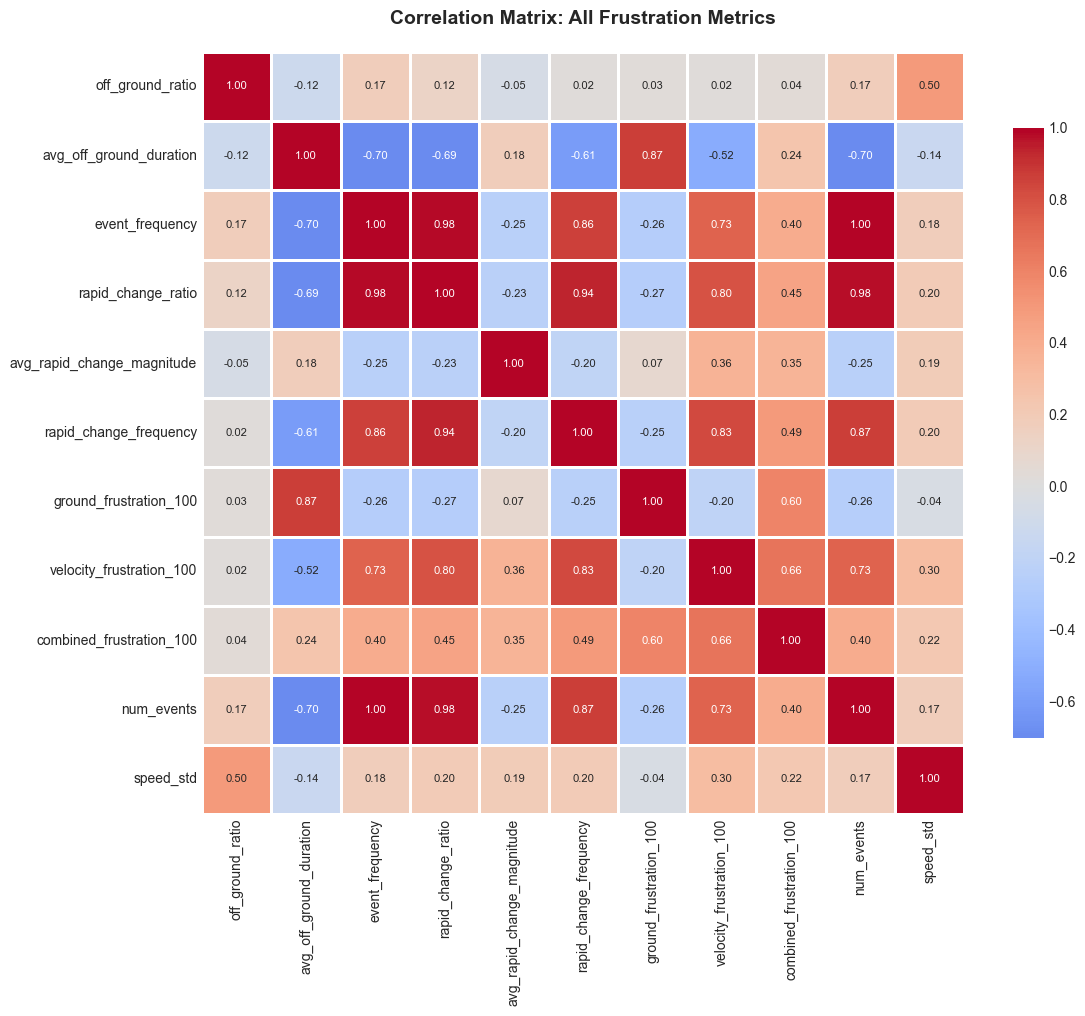

Chart saved as 'correlation_heatmap_all_metrics.png'


In [17]:
# Select numeric columns for correlation - including all three scores
corr_cols = ['off_ground_ratio', 'avg_off_ground_duration', 'event_frequency', 
             'rapid_change_ratio', 'avg_rapid_change_magnitude', 'rapid_change_frequency',
             'ground_frustration_100', 'velocity_frustration_100', 'combined_frustration_100',
             'num_events', 'speed_std']
corr_matrix = frustration_df[corr_cols].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax, annot_kws={'size': 8})
ax.set_title('Correlation Matrix: All Frustration Metrics', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('correlation_heatmap_all_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("Chart saved as 'correlation_heatmap_all_metrics.png'")

## 6. Export Results to CSV

In [18]:
# Export detailed results with ALL THREE SCORES
output_cols = ['session', 'ground_frustration_100', 'velocity_frustration_100', 'combined_frustration_100',
               'off_ground_ratio', 'avg_off_ground_duration', 'event_frequency', 'num_events',
               'rapid_change_ratio', 'avg_rapid_change_magnitude', 'rapid_change_frequency', 'speed_std',
               'total_time', 'total_records', 'track', 'difficulty']

frustration_df[output_cols].to_csv('frustration_analysis_results_all_scores.csv', index=False)
print("✓ Detailed results (all scores) saved to 'frustration_analysis_results_all_scores.csv'")

# Export individual score files for easier comparison
frustration_df[['session', 'ground_frustration_100', 'off_ground_ratio', 
                'avg_off_ground_duration', 'event_frequency', 'track']].to_csv(
    'ground_based_frustration.csv', index=False)
print("✓ Ground-based scores saved to 'ground_based_frustration.csv'")

frustration_df[['session', 'velocity_frustration_100', 'rapid_change_ratio', 
                'avg_rapid_change_magnitude', 'rapid_change_frequency', 'track']].to_csv(
    'velocity_based_frustration.csv', index=False)
print("✓ Velocity-based scores saved to 'velocity_based_frustration.csv'")

frustration_df[['session', 'combined_frustration_100', 'ground_frustration_100', 
                'velocity_frustration_100', 'track']].to_csv(
    'combined_frustration.csv', index=False)
print("✓ Combined scores saved to 'combined_frustration.csv'")

# Export summary statistics for all three score types
summary_stats = pd.DataFrame({
    'Metric': ['Mean Ground Score', 'Median Ground Score', 'Std Dev Ground',
               'Mean Velocity Score', 'Median Velocity Score', 'Std Dev Velocity',
               'Mean Combined Score', 'Median Combined Score', 'Std Dev Combined',
               'Min Combined', 'Max Combined',
               'Mean Off-Ground Ratio (%)', 'Mean Rapid Change Ratio (%)'],
    'Value': [
        f"{frustration_df['ground_frustration_100'].mean():.2f}",
        f"{frustration_df['ground_frustration_100'].median():.2f}",
        f"{frustration_df['ground_frustration_100'].std():.2f}",
        f"{frustration_df['velocity_frustration_100'].mean():.2f}",
        f"{frustration_df['velocity_frustration_100'].median():.2f}",
        f"{frustration_df['velocity_frustration_100'].std():.2f}",
        f"{frustration_df['combined_frustration_100'].mean():.2f}",
        f"{frustration_df['combined_frustration_100'].median():.2f}",
        f"{frustration_df['combined_frustration_100'].std():.2f}",
        f"{frustration_df['combined_frustration_100'].min():.2f}",
        f"{frustration_df['combined_frustration_100'].max():.2f}",
        f"{frustration_df['off_ground_ratio'].mean()*100:.2f}",
        f"{frustration_df['rapid_change_ratio'].mean()*100:.2f}"
    ]
})

summary_stats.to_csv('frustration_summary_statistics.csv', index=False)
print("✓ Summary statistics saved to 'frustration_summary_statistics.csv'")

print("\n" + "="*100)
print("ANALYSIS COMPLETE!")
print("="*100)
print(f"\nGenerated Files:")
print("\nGeneral Analysis:")
print("  1. frustration_scores_comparison.png (compares all 3 scores)")
print("  2. frustration_score_by_session.png")
print("  3. frustration_components_breakdown.png")
print("  4. most_frustrating_session_timeline.png")
print("  5. frustration_distribution.png")
print("  6. frustration_by_track.png")
print("  7. correlation_heatmap.png")
print("\nTrack-Specific Analysis:")
print("  8. track_wise_detailed_analysis.png (4-panel comparison: scores, dominance, consistency, counts)")
print("  9. track_frustration_heatmaps.png (spatial heatmaps showing frustrating sections)")
print(" 10. track_session_profiles.png (session-by-session breakdown for top tracks)")
print("\nData Exports:")
print(" 11. frustration_analysis_results_all_scores.csv (includes all 3 scores)")
print(" 12. ground_based_frustration.csv")
print(" 13. velocity_based_frustration.csv")
print(" 14. combined_frustration.csv")
print(" 15. frustration_summary_statistics.csv")
print(" 16. track_wise_detailed_analysis.csv (track aggregations)")
print(" 17. track_frustrating_sections.csv (spatial grid analysis)")
print("\nAll files are ready for your report!")

✓ Detailed results (all scores) saved to 'frustration_analysis_results_all_scores.csv'
✓ Ground-based scores saved to 'ground_based_frustration.csv'
✓ Velocity-based scores saved to 'velocity_based_frustration.csv'
✓ Combined scores saved to 'combined_frustration.csv'
✓ Summary statistics saved to 'frustration_summary_statistics.csv'

ANALYSIS COMPLETE!

Generated Files:

General Analysis:
  1. frustration_scores_comparison.png (compares all 3 scores)
  2. frustration_score_by_session.png
  3. frustration_components_breakdown.png
  4. most_frustrating_session_timeline.png
  5. frustration_distribution.png
  6. frustration_by_track.png
  7. correlation_heatmap.png

Track-Specific Analysis:
  8. track_wise_detailed_analysis.png (4-panel comparison: scores, dominance, consistency, counts)
  9. track_frustration_heatmaps.png (spatial heatmaps showing frustrating sections)
 10. track_session_profiles.png (session-by-session breakdown for top tracks)

Data Exports:
 11. frustration_analysis_

## 7. Key Insights Summary

### Three Frustration Score Approaches:

#### 1. Ground-Based Score (Original)
$$GroundScore = 0.4 \times OffGroundRatio + 0.4 \times AvgOffGroundDuration_{norm} + 0.2 \times EventFrequency_{norm}$$

**Measures:** Time spent airborne/off-track, duration of off-ground events, frequency of incidents

#### 2. Velocity-Based Score (New)
$$VelocityScore = 0.4 \times RapidChangeRatio + 0.3 \times AvgChangeMagnitude_{norm} + 0.3 \times ChangeFrequency_{norm}$$

**Measures:** Rapid velocity changes (collisions, sudden stops), magnitude of speed changes, frequency of disruptions

#### 3. Combined Score (Comprehensive)
$$CombinedScore = 0.5 \times GroundScore + 0.5 \times VelocityScore$$

**Measures:** Both stability (ground control) AND smoothness (velocity consistency)

### Methodology Details:

#### Ground-Based Metrics:
1. **Off-Ground Ratio**: Direct measure of time spent airborne/off-track (0-1 scale)
2. **Average Off-Ground Duration**: Normalized duration to measure recovery time
3. **Event Frequency**: Normalized events per minute

#### Velocity-Based Metrics:
1. **Rapid Change Ratio**: Proportion of timesteps with velocity change > threshold (5 units)
2. **Average Rapid Change Magnitude**: Mean size of rapid velocity changes
3. **Rapid Change Frequency**: Number of rapid changes per minute
4. **Speed Standard Deviation**: Overall speed stability measure

### Interpretation Guide:

#### Score Ranges (0-100):
- **0-20**: Excellent - minimal frustration, smooth control
- **20-40**: Good - occasional challenges, generally controlled
- **40-60**: Moderate - frequent issues, noticeable difficulty
- **60-80**: High - significant frustration, poor control
- **80-100**: Extreme - very frustrating, constant problems

### Key Differences Between Score Types:

- **Ground-Based**: Best for tracks with jumps, rough terrain, off-track incidents
- **Velocity-Based**: Best for detecting collisions, tight corners, traffic issues
- **Combined**: Best overall measure capturing multiple frustration dimensions

### Use Cases for Report:
1. **Performance Evaluation**: Identify most challenging sessions across different difficulty aspects
2. **Track Difficulty Analysis**: Compare tracks using multiple frustration dimensions
3. **Skill Assessment**: Ground scores show track control; velocity scores show smoothness
4. **Game Balancing**: Use combined score for overall difficulty, individual scores for specific improvements
5. **Player Experience**: Velocity frustration may indicate collision/traffic issues; ground frustration indicates track design issues

### Advantages of Multi-Score Approach:
- **More Comprehensive**: Captures different types of frustration
- **Better Diagnostics**: Pinpoints specific problem areas (control vs. collision)
- **Flexible Analysis**: Can weight different aspects based on research goals
- **Validation**: Multiple metrics provide cross-validation of difficulty